# Data Preparation, Analysis, and Discussion

Having collected the data from Gutendex API, I can now prepare, analyse, and discuss the data. 

I will clean the data, refining the JSON dataset for accuracy and consistency. The, I will use analytical techniques to discover patterns, trends, and valuable insights within the dataset.

In [300]:
#Importing useful libraries
import json
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline

Directories for data storage

In [301]:
#raw data storage
dir_raw = Path("raw")
#clean pre-processed data
dir_data = Path("data")
#make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)

## Data Preprocesing

I will transform the raw data into a suitable format for analysis. This is crucial to ensure the data is accurate, consistent, and ready for analysis. 

I will parse and merge the raw data into a structured Dataframe for easier data manipulation and analysis. 

Then, I will inspect for missing values. Columns with mostly empty values will be removed for efficiency.

A significant challenge here arises from columns containing lists and dictionaries as values. The long and complex values must be dealt with for easier analysis. I will analyse each multi-valued column to devise the most optimal approach for data expansion, either breaking them into individual entries, or creating new columns to hold the individual fields.

This will hopefully tranform the DataFrame into a clean, comprehensible format for interpretation and analysis. 

### Data Loading and Parsing
Find raw JSON files and parse them into a dataframe:

In [302]:
raw_files = []
for fpath in dir_raw.iterdir():
    if fpath.suffix == ".json":
        raw_files.append(fpath)

print("Found %s raw data files" % len(raw_files))

Found 1000 raw data files


In [303]:
def parse_raw_data(fpath):
    fin = open(fpath, "r")
    jdata = fin.read()
    books = json.loads(jdata)
    #books is a list of dicts, each dict is a book entry
    fin.close()
    return pd.DataFrame(books)

file1 = parse_raw_data(raw_files[0])

I will merge all of the files into one large DataFrame:

In [304]:
def parse_merge_raw_data(fpaths):
    df_files = []
    print("Reading and parsing %d JSON data files ..." % len(fpaths))
    for fpath in fpaths:
        #make a list of dataframes, one dataframe for each file
        df_file = parse_raw_data(fpath)
        df_files.append(df_file)
    #Merge dataframes into one dataframe
    df_books = pd.concat(df_files)
    #Remove duplicate ids
    df_books.drop_duplicates(subset="id", keep="first", inplace=True)
    #Set index column to id, which is now unique
    df_books.set_index("id", inplace=True)
    #sort by id
    return df_books.sort_index()

Parse and merge raw data files to produce a single merged Pandas DataFrame

In [305]:
df_books = parse_merge_raw_data(raw_files)

Reading and parsing 1000 JSON data files ...


## Data Verification
Check format of some rows in DataFrame

In [306]:
df_books.head(5)

,title,authors,translators,subjects,bookshelves,languages,copyright,media_type,formats,download_count
id,,,,,,,,,,
1,The Declaration of Independence of the United ...,"[{'name': 'Jefferson, Thomas', 'birth_year': 1...",[],"[United States -- History -- Revolution, 1775-...","[American Revolutionary War, Politics, United ...",[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,1657
2,The United States Bill of Rights: The Ten Orig...,"[{'name': 'United States', 'birth_year': None,...",[],"[Civil rights -- United States -- Sources, Uni...","[American Revolutionary War, Politics, United ...",[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,1072
3,John F. Kennedy's Inaugural Address,"[{'name': 'Kennedy, John F. (John Fitzgerald)'...",[],[Presidents -- United States -- Inaugural addr...,[],[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,379
4,Lincoln's Gettysburg Address: Given November 1...,"[{'name': 'Lincoln, Abraham', 'birth_year': 18...",[],[Consecration of cemeteries -- Pennsylvania --...,[US Civil War],[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,409
5,The United States Constitution,"[{'name': 'United States', 'birth_year': None,...",[],[United States -- Politics and government -- 1...,"[American Revolutionary War, Politics, United ...",[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,677


In [307]:
#Check number of rows and columns
df_books.shape

(31220, 10)

I can see that I have over 31,000 book entries, with 10 columns/fields to describe each entry.

## Cleaning data

### Missing Data

In [308]:
#Checking for missing values
def check_missing_values(df):
    print("Checking missing values in each field:")
    for field in df:
        print("Field %s: %d missing values." % (field, df[field].isnull().sum()))

In [309]:
print("Dataframe: df_books")
check_missing_values(df_books)

Dataframe: df_books
Checking missing values in each field:
Field title: 0 missing values.
Field authors: 0 missing values.
Field translators: 0 missing values.
Field subjects: 0 missing values.
Field bookshelves: 0 missing values.
Field languages: 0 missing values.
Field copyright: 0 missing values.
Field media_type: 0 missing values.
Field formats: 0 missing values.
Field download_count: 0 missing values.


On first glance, the DataFrame has no null values. However, a closer look to the DataFrame shows fields with empty lists and dictionaries, for example, within the "translators" field. I will identify and remove these empty data structures. This will ensure the data remains coherent and clear.

### Empty Data Structures

I have created a method to filter row entries with empty lists/dictionaries as values. 

Although this will reduce the dataset's size, it is necessary for proper and meaningful analysis. It will streamline the dataset and guarantee the quality and relevance of the remaining data.

## Expanding Data Structures

I will expand the multi-valued fields to make them easier to read, access, and analyse:

- "authors" and "translators" are both lists of dictionaries

- "subjects", "bookshelves", and "languages" are lists of strings.

- "formats" is a dictionary.

### "authors"

For books with a single author, I will create three new columns, "author_name", "author_birth_year" and "author_death_year", to store the data of the author.

If the number of books with multiple authors is very small compared to single-author books, I will eliminate those book entries. This will optimise the dataset by reducing empty values and enhance later data analysis.

In [310]:
# I will create a function to check the number of occurrences of a certain field
def check_frequency_of_value(df, field, value):
    count = 0
    for i in range(len(df)):
        if len(df[field].iloc[i]) > value:
            count += 1

    print("Number of books with more than %d %s: %d" % (value, field, count))
    print("Percentage of books with more than %d %s: %.2f%%" % (value, field, count/len(df) * 100))

In [311]:
#Check number of books with multiple authors
check_frequency_of_value(df_books, "authors", 1)

Number of books with more than 1 authors: 1410
Percentage of books with more than 1 authors: 4.52%


We can see that less than 5% of books are written by multiple authors. 

I will filter out co-authored books as a redundant column of co-authors would be null for over 95% of book entries.

In [312]:
#delete books with multiple authors

for index, row in df_books.iterrows():
    if len(row["authors"]) > 1:
        df_books.drop(index, inplace=True)

In [313]:
#Reduced number of rows
df_books.shape

(29810, 10)

In [314]:
#Check number of books with one author or less
value = 1
field = "authors"

count = 0
for i in range(len(df_books)):
    if len(df_books[field].iloc[i]) <= value:
        count += 1

print("Number of books with one author or less: %d" % (count))
print("Percentage of books with one author or less: %.2f%%" % (count/len(df_books) * 100))

Number of books with one author or less: 29810
Percentage of books with one author or less: 100.00%


All books are now confirmed to have been written by a single author, or have no author.

I will check for missing values again.

### Missing Data

In [315]:
check_missing_values(df_books)

Checking missing values in each field:
Field title: 0 missing values.
Field authors: 0 missing values.
Field translators: 0 missing values.
Field subjects: 0 missing values.
Field bookshelves: 0 missing values.
Field languages: 0 missing values.
Field copyright: 0 missing values.
Field media_type: 0 missing values.
Field formats: 0 missing values.
Field download_count: 0 missing values.


In [316]:
#Delete missing values
df_books = df_books.dropna()

Now we have a clean dataframe with no missing values.

I will now create the 3 new columns for the author, and give them the values of the first author in the authors column.

A warning will be given as I am changing parts of the DataFrame, but this can be ignored as I am intentionally modifiying the DataFrame.

In [317]:
#Collapsing authors column

#initialise new columns
df_books["author_name"] = ""
df_books["author_birth_year"] = 0
df_books["author_death_year"] = 0

for i in df_books.index:
    #If an author is given - expand
    if (len(df_books["authors"].loc[i]) > 0):
        df_books["author_name"].loc[i] = df_books["authors"].loc[i][0]["name"]
        df_books["author_birth_year"].loc[i] = df_books["authors"].loc[i][0]["birth_year"]
        df_books["author_death_year"].loc[i] = df_books["authors"].loc[i][0]["death_year"]

C:\Users\amyta\AppData\Local\Temp\ipykernel_4276\2005291517.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books["author_name"].loc[i] = df_books["authors"].loc[i][0]["name"]
C:\Users\amyta\AppData\Local\Temp\ipykernel_4276\2005291517.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books["author_birth_year"].loc[i] = df_books["authors"].loc[i][0]["birth_year"]
C:\Users\amyta\AppData\Local\Temp\ipykernel_4276\2005291517.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [318]:
#Deleting authors column as it is now redundant
del df_books["authors"]

In [319]:
df_books.head(5)

,title,translators,subjects,bookshelves,languages,copyright,media_type,formats,download_count,author_name,author_birth_year,author_death_year
id,,,,,,,,,,,,
1,The Declaration of Independence of the United ...,[],"[United States -- History -- Revolution, 1775-...","[American Revolutionary War, Politics, United ...",[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,1657,"Jefferson, Thomas",1743.0,1826.0
2,The United States Bill of Rights: The Ten Orig...,[],"[Civil rights -- United States -- Sources, Uni...","[American Revolutionary War, Politics, United ...",[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,1072,United States,NaN,NaN
3,John F. Kennedy's Inaugural Address,[],[Presidents -- United States -- Inaugural addr...,[],[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,379,"Kennedy, John F. (John Fitzgerald)",1917.0,1963.0
4,Lincoln's Gettysburg Address: Given November 1...,[],[Consecration of cemeteries -- Pennsylvania --...,[US Civil War],[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,409,"Lincoln, Abraham",1809.0,1865.0
5,The United States Constitution,[],[United States -- Politics and government -- 1...,"[American Revolutionary War, Politics, United ...",[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,677,United States,NaN,NaN


Unfortunately, there are still some missing values in the author birth year and death year.

For example, the author of "The United States Constitution" is the United States, which has no birth year or death year.

In [320]:
check_missing_values(df_books)

Checking missing values in each field:
Field title: 0 missing values.
Field translators: 0 missing values.
Field subjects: 0 missing values.
Field bookshelves: 0 missing values.
Field languages: 0 missing values.
Field copyright: 0 missing values.
Field media_type: 0 missing values.
Field formats: 0 missing values.
Field download_count: 0 missing values.
Field author_name: 0 missing values.
Field author_birth_year: 4406 missing values.
Field author_death_year: 4792 missing values.


I will perform the same strategy as with the co-authored books, checking the percentage of missing birth years and death years:

In [321]:
print("Percentage of books with no author birth year: %.2f%%" % (df_books["author_birth_year"].isnull().sum()/len(df_books) * 100))
print("Percentage of books with no author deah year: %.2f%%" % (df_books["author_death_year"].isnull().sum()/len(df_books) * 100))

Percentage of books with no author birth year: 14.78%
Percentage of books with no author deah year: 16.08%


Given that approximately 15% of books lack a birth year or death year of the author, I will choose to retain these book entries by setting the null values to a recognisable constant - 0. 

This will enable me to conduct analysis while being mindful of incomplete data. I may choose to include or exclude these entries for specific analyses. 

Excluding the entries will remove any potential bias in analysis.

In [322]:
df_books.fillna(0)

,title,translators,subjects,bookshelves,languages,copyright,media_type,formats,download_count,author_name,author_birth_year,author_death_year
id,,,,,,,,,,,,
1,The Declaration of Independence of the United ...,[],"[United States -- History -- Revolution, 1775-...","[American Revolutionary War, Politics, United ...",[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,1657,"Jefferson, Thomas",1743.0,1826.0
2,The United States Bill of Rights: The Ten Orig...,[],"[Civil rights -- United States -- Sources, Uni...","[American Revolutionary War, Politics, United ...",[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,1072,United States,0.0,0.0
3,John F. Kennedy's Inaugural Address,[],[Presidents -- United States -- Inaugural addr...,[],[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,379,"Kennedy, John F. (John Fitzgerald)",1917.0,1963.0
4,Lincoln's Gettysburg Address: Given November 1...,[],[Consecration of cemeteries -- Pennsylvania --...,[US Civil War],[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,409,"Lincoln, Abraham",1809.0,1865.0
5,The United States Constitution,[],[United States -- Politics and government -- 1...,"[American Revolutionary War, Politics, United ...",[en],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,677,United States,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
71799,New-Englands plantation : $b with the sea jour...,[],[New England -- Description and travel -- Earl...,[],[en],False,Text,{'application/octet-stream': 'https://www.gute...,540,"Higginson, Francis",1587.0,1630.0
71800,Formula for murder,[],"[Murder -- Fiction, Psychiatrists -- Fiction, ...",[],[en],False,Text,{'application/octet-stream': 'https://www.gute...,419,"Rothman, Milton A.",1919.0,2001.0
71803,Malmedy und die preußische Wallonie : $b Skizz...,[],"[Malmédy (Belgium), Wallonia (Belgium)]",[],[de],False,Text,{'application/octet-stream': 'https://www.gute...,70,"Kellen, Tony",1869.0,1948.0


### "translators"

It seems that most books do not include a translator.

I will check for the frequency of books with translators to see if I should keep "translators" as a column. 

If the frequency is low, I may delete the column.

In [323]:
#Check number of books with translators
check_frequency_of_value(df_books, "translators", 0)

Number of books with more than 0 translators: 2833
Percentage of books with more than 0 translators: 9.50%


"translators" information is available for less than 10% of the books. 

Given that it is null for over 90% of books, I have decided to remove the "translators" column. I believe that retaining it will not significantly contribute to the analysis.

In [324]:
del df_books["translators"]

### "subjects" and "bookshelves"

These columns are uniquely challenging. Unlike "authors", there isn't a fixed number of subjects or bookshelves for each book. Instead, they contain multiple strings of different categories. They are also almost always present in books. 

Given this variability, I have chosen to not create new columns for these fields, as it would not accurate represent the diverse nature of the data.

Instead, I will retain these columns in their original form. During analyis, I will use the function "explode()" to transform the multi-valued cells into individual rows, creating a more granular dataset. 

This will allow for comprehensive, in-depth analysis of the diverse literary classifications in the dataset, all while preserving the complexity of the data.

### "languages"

Like "authors", most books contain only one value for this column. So, I will check how many books are written in multiple languages.

In [325]:
#Check number of books with multiple languages
check_frequency_of_value(df_books, "languages", 1)

Number of books with more than 1 languages: 127
Percentage of books with more than 1 languages: 0.43%


The number of books in different languages is extremely low, less than 0.5%. 

So, like the "authors" column, I will delete the entries with multiple languages, and expand the columns with only one language.

In [326]:
#delete books with multiple languages

for index, row in df_books.iterrows():
    if len(row["languages"]) > 1:
        df_books.drop(index, inplace=True)

In [327]:
df_books.shape

(29683, 11)

Now I will check for the number of books with no languages:

In [328]:
check_frequency_of_value(df_books, "languages", 0)

Number of books with more than 0 languages: 29683
Percentage of books with more than 0 languages: 100.00%


Fortunately, there are no null values, so we can continue with collapsing this column.

In [329]:
#Collapsing languages column

#initialise new column

df_books["language"] = ""

for i in df_books.index:
    #If an author is given - expand
    if (len(df_books["languages"].loc[i]) > 0):
        df_books["language"].loc[i] = df_books["languages"].loc[i][0]

C:\Users\amyta\AppData\Local\Temp\ipykernel_4276\3096041624.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books["language"].loc[i] = df_books["languages"].loc[i][0]


In [330]:
#Delete original column
del df_books["languages"]

In [331]:
df_books.head(5)

,title,subjects,bookshelves,copyright,media_type,formats,download_count,author_name,author_birth_year,author_death_year,language
id,,,,,,,,,,,
1,The Declaration of Independence of the United ...,"[United States -- History -- Revolution, 1775-...","[American Revolutionary War, Politics, United ...",False,Text,{'application/x-mobipocket-ebook': 'https://ww...,1657,"Jefferson, Thomas",1743.0,1826.0,en
2,The United States Bill of Rights: The Ten Orig...,"[Civil rights -- United States -- Sources, Uni...","[American Revolutionary War, Politics, United ...",False,Text,{'application/x-mobipocket-ebook': 'https://ww...,1072,United States,NaN,NaN,en
3,John F. Kennedy's Inaugural Address,[Presidents -- United States -- Inaugural addr...,[],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,379,"Kennedy, John F. (John Fitzgerald)",1917.0,1963.0,en
4,Lincoln's Gettysburg Address: Given November 1...,[Consecration of cemeteries -- Pennsylvania --...,[US Civil War],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,409,"Lincoln, Abraham",1809.0,1865.0,en
5,The United States Constitution,[United States -- Politics and government -- 1...,"[American Revolutionary War, Politics, United ...",False,Text,{'application/x-mobipocket-ebook': 'https://ww...,677,United States,NaN,NaN,en


### Formats

I will check how many books contain format data:

In [332]:
#Check number of books with formats
check_frequency_of_value(df_books, "formats", 0)
check_frequency_of_value(df_books, "formats", 6)

Number of books with more than 0 formats: 29683
Percentage of books with more than 0 formats: 100.00%
Number of books with more than 6 formats: 28024
Percentage of books with more than 6 formats: 94.41%


"formats" present a similar challenge to the columns "subjects" and "bookshelves", having a variable number of formats for each book.

Most books contain at least 6 formats. Creating individual columns for each format would be impractical.

I will choose to retain this column in its current state, and use the "explode()" function later on for data analysis. This will preserve the diversity of formats, and allow for comprehensive data analysis.

## Cleaned DataFrame

Our Data Preparation is complete. 

Now, we can take a look at the final cleaned DataFrame.

Our data is now easier to read and analyse.

In [333]:
df_books.sample(5)

,title,subjects,bookshelves,copyright,media_type,formats,download_count,author_name,author_birth_year,author_death_year,language
id,,,,,,,,,,,
56691,Saturday Night Thoughts: A Series of Dissertat...,[Mormon Church],[Latter Day Saints],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,46,"Whitney, Orson F. (Orson Ferguson)",1855.0,1931.0,en
52539,Beautiful Wales,[Wales -- Description and travel],[],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,38,"Thomas, Edward",1878.0,1917.0,en
56911,The New Century Standard Letter-Writer: Busine...,[Letter writing],[],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,54,"Chambers, Alfred B.",NaN,NaN,en
22447,Poems of Gerard Manley Hopkins,[Poetry],[],False,Text,{'application/rdf+xml': 'https://www.gutenberg...,60,"Hopkins, Gerard Manley",1844.0,1889.0,en
42384,"Scandinavians on the Pacific, Puget Sound","[Scandinavian Americans, Washington (State) --...",[],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,37,"Stine, Thomas Ostenson",NaN,NaN,en


## Data Saving

Now I can write out the DataFrame in JSON format. 

This will represent the 'clean' data that we will use next for our actual data analysis:

In [334]:
fname = "gutendex.json"
out_path = dir_data / fname
print("Writing %s" % out_path)
df_books.to_json(out_path, orient="index", indent=4)

Writing data\gutendex.json


## Data Loading

Loading stored dataframe. This step can be skipped.

In [335]:
fname = "gutendex.json"
in_path = dir_data / fname
df_books = pd.read_json(in_path, orient="index")
print("%d rows of data loaded." % len(df_books))

29683 rows of data loaded.


In [336]:
df_books.head(2)

,title,subjects,bookshelves,copyright,media_type,formats,download_count,author_name,author_birth_year,author_death_year,language
1,The Declaration of Independence of the United ...,"[United States -- History -- Revolution, 1775-...","[American Revolutionary War, Politics, United ...",False,Text,{'application/x-mobipocket-ebook': 'https://ww...,1657,"Jefferson, Thomas",1743.0,1826.0,en
2,The United States Bill of Rights: The Ten Orig...,"[Civil rights -- United States -- Sources, Uni...","[American Revolutionary War, Politics, United ...",False,Text,{'application/x-mobipocket-ebook': 'https://ww...,1072,United States,NaN,NaN,en


## Data Analysis

Our current DataFrame has missing values, so I will create a new DataFrame with no missing values for the sake of accuracy in some analyses.

I will also delete any years of the value 0, and author name whitepace values as they are invalid.

In [337]:
df_books_complete = df_books.dropna()
df_books_complete = df_books_complete[(df_books_complete["author_name"] != "") &(df_books_complete["author_birth_year"] != 0) & (df_books_complete["author_death_year"] != 0)]

df_books_complete.shape

(22980, 11)

As we can see, the complete DataFrame contains approximately 5000 less books.

### General Numerical Analysis
Looking at raw statistics for numerical data.

In [338]:
df_books.describe()

,download_count,author_birth_year,author_death_year
count,29683.000000,25314.000000,24927.000000
mean,196.408517,1700.866438,1758.786697
std,1130.453285,488.817629,509.696462
min,36.000000,-750.000000,-650.000000
25%,46.000000,1811.000000,1875.000000
50%,68.000000,1848.000000,1915.000000
75%,119.000000,1868.000000,1939.000000
max,68248.000000,1982.000000,2023.000000


In [339]:
df_books_complete.describe()

,download_count,author_birth_year,author_death_year
count,22980.000000,22980.000000,22980.000000
mean,213.628895,1803.151349,1872.924935
std,1265.259877,257.995693,258.878334
min,36.000000,-750.000000,-650.000000
25%,46.000000,1819.000000,1887.000000
50%,68.000000,1850.000000,1918.000000
75%,121.000000,1868.000000,1941.000000
max,68248.000000,1970.000000,2023.000000


The values of author birth year and death year very slightly change for complete data in comparision to data with missing values. The only major change I see is the standard deviation of the years, which makes sense if years were skewed to the value 0. The completed data is more accurate, and will be taken into account for this analysis.

The negative values in birth year and death year indicate books authored in BC ('Before Christ') years, while positive values correspond to AD years ('Anno Domini' - After Christ). This distinction helped categorise the historical timelines of authors, so that we can understand the dataset across different eras.

We can also see a wide range of download counts, from a minimum of 36 to a maximum of 68,248 downloads, with an average of approximately 211 downloads per book. The distribution is positively skewed, as the mean is higher than the 75% percentile.

Author birth years range from 750 BC to 1970 AD, with the majority being born around the 1850s, and with an average birth year of 1695. We can also see great variation in the standard deviation of 257 years.

Author death years are similar, from 650 BC to as modern as 2023 AD. Most authors passed away in the 1900s. As expected, there is a similar standard deviation as in birth years.

### Author age
I will create a new column "author_age", which is the author's death year - birth year. This will give us more information about the authors' lifespans throughout the centuries.

In [340]:
df_books["author_age"] = df_books["author_death_year"] - df_books["author_birth_year"]
df_books_complete["author_age"] = df_books_complete["author_death_year"] - df_books_complete["author_birth_year"]

In [341]:
df_books["author_age"].describe()

count    24441.000000
mean        65.602758
std         21.320923
min          0.000000
25%         59.000000
50%         70.000000
75%         79.000000
max        107.000000
Name: author_age, dtype: float64

In [342]:
df_books_complete["author_age"].describe()

count    22980.000000
mean        69.773586
std         13.872912
min         18.000000
25%         61.000000
50%         71.000000
75%         80.000000
max        107.000000
Name: author_age, dtype: float64

We can see that the null values give an inaccurate minimum age, as well as skew the standard deviation.

Age varies from 18 to 107 years old, showing great variation. Most authors tend to be about 70 years old, with an standard deviation of about 14 years.

#### Youngest Authors
Looking at the books with the youngest authors, we can see which subjects were most common, as well as the time they lived in.

In [343]:
df_youngest_authors = df_books_complete.sort_values(by="author_age").head(500)

df_youngest_authors["author_age"].value_counts()

35.0    75
30.0    54
36.0    50
37.0    47
29.0    42
32.0    36
34.0    32
33.0    31
38.0    27
31.0    24
26.0    21
28.0    17
25.0    12
27.0    11
24.0     9
23.0     4
20.0     3
21.0     3
22.0     1
18.0     1
Name: author_age, dtype: int64

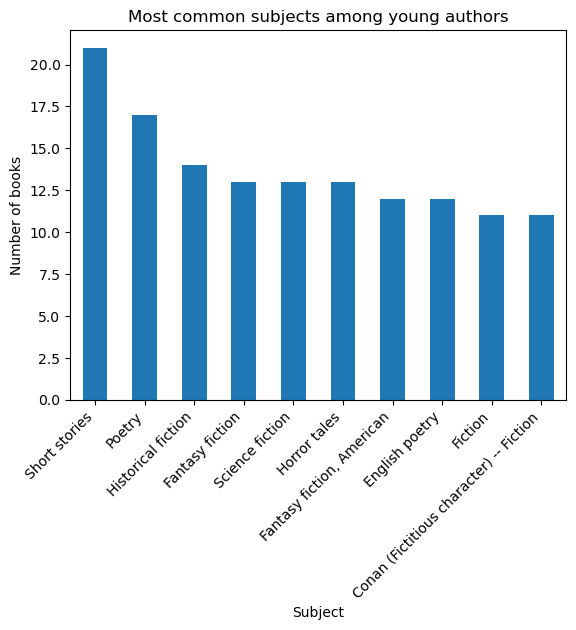

In [395]:
#Most common subjects among young authors
df_youngest_authors['subjects'].explode().value_counts().head(10).plot(kind="bar")
plt.ylabel("Number of books")
plt.xlabel("Subject")
plt.xticks(rotation=45, ha="right")
plt.title("Most common subjects among young authors");

Text(0.5, 1.0, 'Frequency of young authors throughout the centuries')

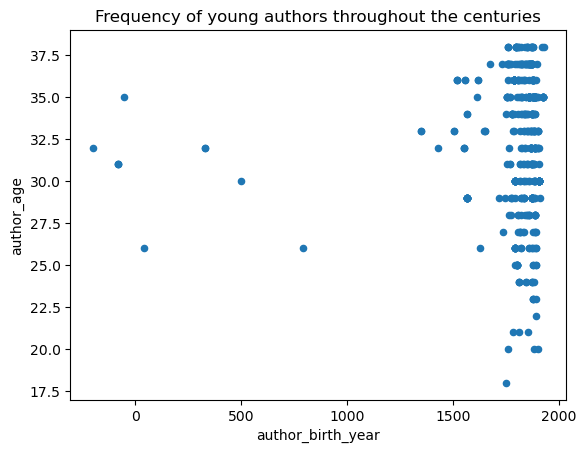

In [345]:
#Frequency of young authors throughout the centuries
df_youngest_authors.plot(kind="scatter", y="author_age", x="author_birth_year")
plt.title("Frequency of young authors throughout the centuries")

Summary of the Youngest Authors:

The first 500 youngest authors are in the age bracket [18-38] years old.

These authors predominantly wrote on subjects such as short stories, poetry, and fiction.

We can also see that young authors were most common between the 1500s and 2000s, with most living to around 35 years old. 

#### Eldest Authors
Now I will do the same analysis for the eldest authors:

In [346]:
df_eldest_authors = df_books_complete.sort_values(by="author_age", ascending=False).head(500)

df_eldest_authors["author_age"].value_counts()

94.0     196
98.0      56
95.0      55
96.0      45
97.0      44
93.0      43
100.0     40
99.0       8
101.0      4
102.0      3
107.0      2
103.0      2
106.0      1
104.0      1
Name: author_age, dtype: int64

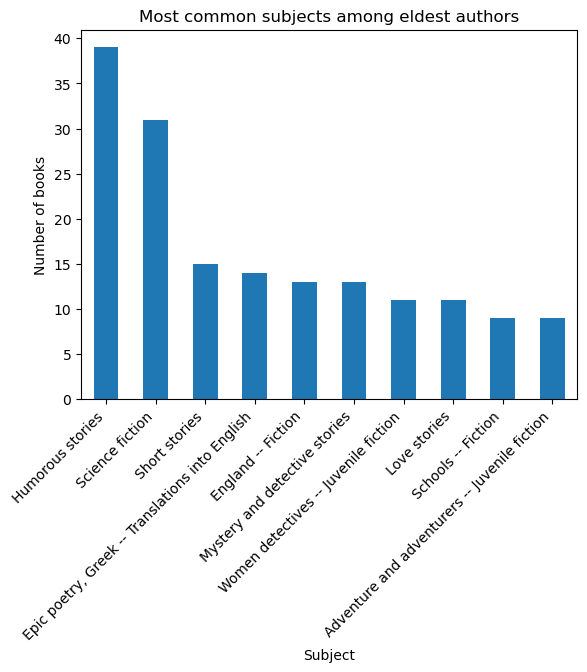

In [396]:
#Most common subjects among old authors
df_eldest_authors['subjects'].explode().value_counts().head(10).plot(kind="bar")
plt.ylabel("Number of books")
plt.xlabel("Subject")
plt.xticks(rotation=45, ha="right")
plt.title("Most common subjects among eldest authors");

Text(0.5, 1.0, 'Frequency of old authors throughout the centuries')

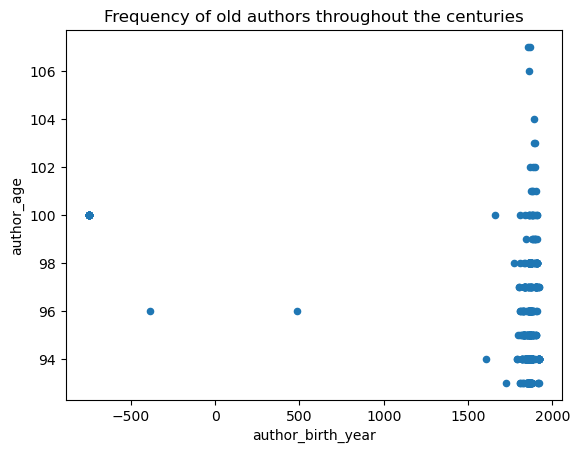

In [348]:
#Frequency of old authors throughout the centuries
df_eldest_authors.plot(kind="scatter", y="author_age", x="author_birth_year")
plt.title("Frequency of old authors throughout the centuries")

Summary of the Eldest Authors:

The first 500 eldest authors are in the age bracket [93-107] years old.

Like young authors, many wrote about science fiction and short stories. These may be popular subjects for all authors. Surprisingly, eldest authors most commonly wrote about humorous stories.

We can also see that old authors were most common between the 1500s and 2000s, like young authors. This suggests that the majority of books are in this era, which is expected. Most old authors were 100 years old or younger. Few lived to over a century.

#### General Author Age

Looking at all author ages, we can see the distribution of author ages for all books

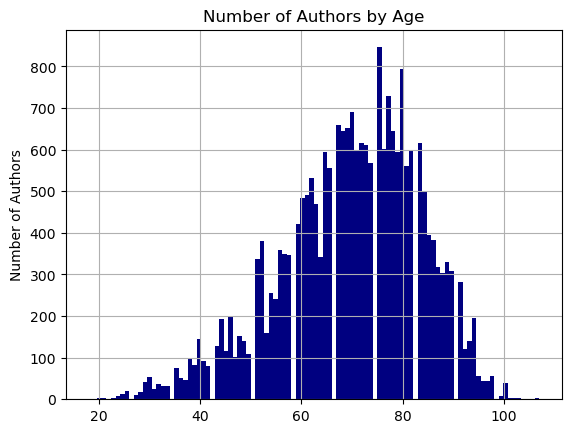

In [349]:
df_books_complete["author_age"].hist(bins=100, color="navy")
plt.ylabel("Number of Authors")
plt.title("Number of Authors by Age");

We can see the distribution of author ages, with most around 70 years old, as the mean calculated.

We can also create a new column "author_age_category" to divide age into categories.

Age groups will be 10-110 with 10 years difference.

In [350]:
bins = []
for i in range(10, 111, 10):
    bins.append(i)
bins

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

In [351]:
df_books["author_age_category"] = pd.cut(df_books["author_age"], bins=bins, right=False)

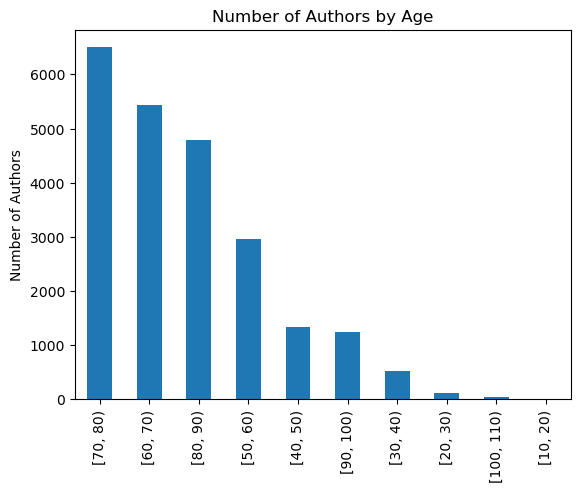

In [352]:
#Ordering by most common frequencies
age_counts = df_books["author_age_category"].value_counts()
age_counts.plot(kind="bar")
plt.ylabel("Number of Authors")
plt.title("Number of Authors by Age");

Now we can see the most common age brackets more clearly. Most authors were found to be between 60 and 90 years old.

### Popularity of Books

Here we can see the popularity of books over time by download count. This will help assess which times were most popular.

(-750.0, 2023.0)

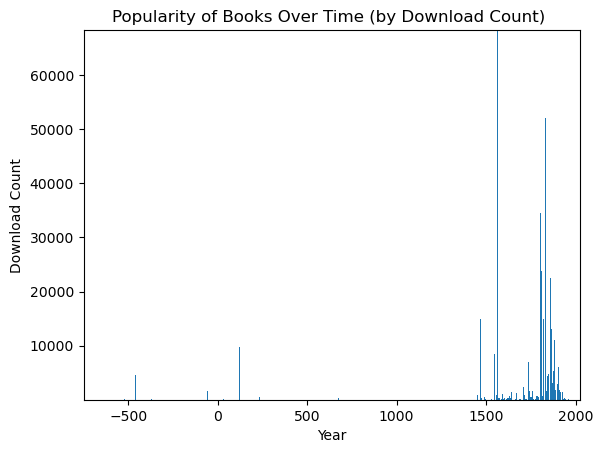

In [353]:
plt.bar(df_books["author_birth_year"],df_books["download_count"])
plt.title("Popularity of Books Over Time (by Download Count) ")
plt.xlabel("Year")
plt.ylabel("Download Count")
# adjust the axis limits
plt.ylim(df_books["download_count"].min(), df_books["download_count"].max())
plt.xlim(df_books["author_birth_year"].min(), df_books["author_death_year"].max())

We can see that books were not very popular before the 1500s. The surge in book popularity after the 1500s can be attributed to the invention of the printing press by Gutenberg around 1440 AD. With the mass production of books and the subsequent rise in literacy rates, reading became widespread, leading to a significant increase in the popularity of books.

To visually capture this historical trend, I will generate an updated graph focusing on the period between 1440 and 2000. This timeframe marks a pivotal era in the evolution of literature, reflecting the profound impact of printing technology on book accessibility and readership.

(1440.0, 2000.0)

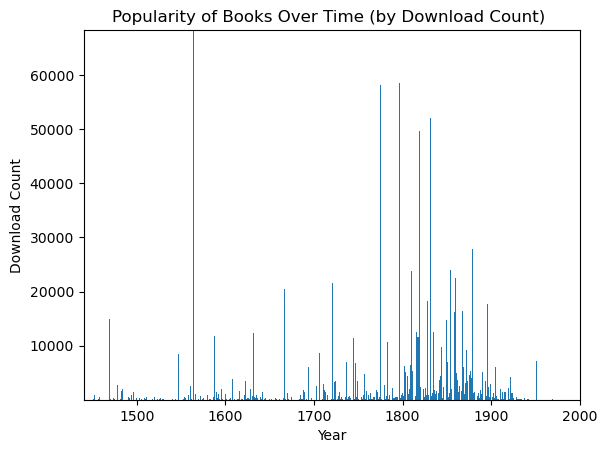

In [354]:
plt.bar(df_books["author_birth_year"],df_books["download_count"])
plt.title("Popularity of Books Over Time (by Download Count) ")
plt.xlabel("Year")
plt.ylabel("Download Count")
# adjust the axis limits
plt.ylim(df_books["download_count"].min(), df_books["download_count"].max())
plt.xlim(1440, 2000)

Books were incredibly more frequent at this time period, mirroring the impact of the printing press.

The spike of download counts near the 1570s is from the play "Romeo and Juliet" by Shakespeare, which is the most commonly downloaded book in the Gutendex.

We can also see that books were most common between the 1800s and 1900s. 

The increase in frequency of books at this time is due to technological advancements in the printing press. The printing press became more mechanised and more widely adopted, triggering a revolution in paper production and book publishing.

### Most Common Authors

This will be an analysis of the most frequent authors in the Gutendex.

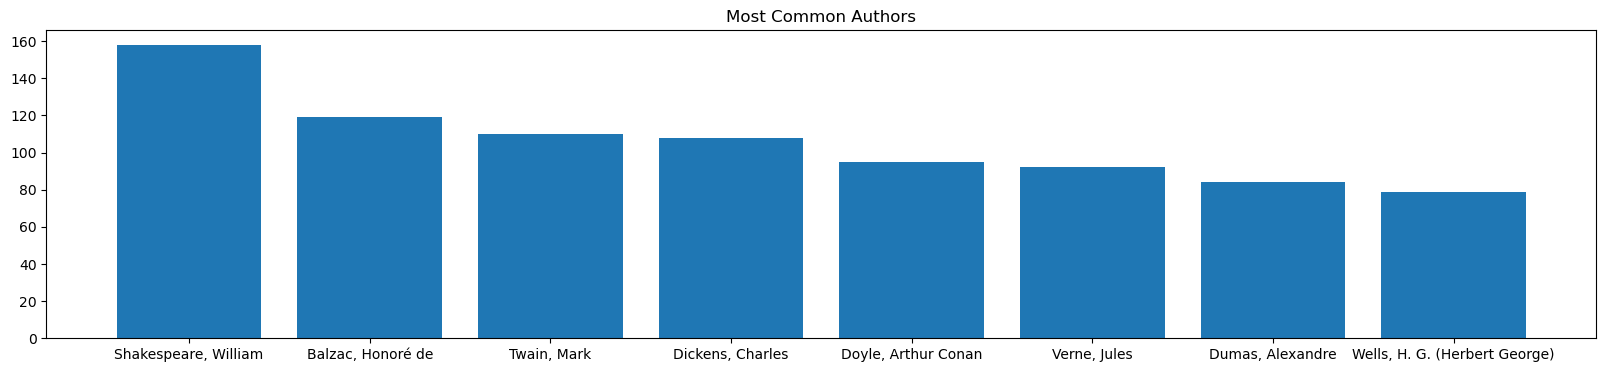

In [355]:
#Most common authors + number of their works
plt.figure(figsize=(20, 4))
ser = df_books_complete["author_name"].value_counts().head(8)
books = ser.tolist()
authors = ser.index.values.tolist()

df = pd.DataFrame({"books": books, "authors": authors})
df.set_index("authors")

plt.bar(df["authors"], df["books"])
plt.title("Most Common Authors");

As expected, we see one of the most popular authors and playwright of all time - William Shakespeare - with over 150 books.

We also see other popular authors like Mark Twain, Charles Dickens, and Arthur Conan Doyle.

### Conclusion:

The current size of the data is very large, so it takes a long time for the graphs to load. 

For this reason, I will filter the data down based on various criteria and perform individual data analysis on each part.

## Data Filtering

### Searching for keywords
### Banned Books 

The following code can filter a column (series) of type list in order to search the list for a keyword and return the entries that contain that keyword in that column. The keyword can be a substring of a string in the list.

I use lambda to create an anonymous function that checks for any occurrence of the keyword in the specified column.

I will use the DataFrame with missing author information - df_books - in order to extract as many banned books as possible.

In [356]:
#E.g. search for banned books
df_banned_books = df_books[df_books["bookshelves"].apply(lambda x: any("Banned Book" in item for item in x))]
df_banned_books.head(5)

,title,subjects,bookshelves,copyright,media_type,formats,download_count,author_name,author_birth_year,author_death_year,language,author_age,author_age_category
10,The King James Version of the Bible,[Bible],[Banned Books List from the American Library A...,False,Text,{'application/octet-stream': 'https://www.gute...,6154,,0.0,0.0,en,0.0,NaN
20,Paradise Lost,"[Adam (Biblical figure) -- Poetry, Bible. Gene...","[Banned Books from Anne Haight's list, Poetry]",False,Text,{'application/x-mobipocket-ebook': 'https://ww...,1687,"Milton, John",1608.0,1674.0,en,66.0,"[60.0, 70.0)"
74,"The Adventures of Tom Sawyer, Complete","[Adventure stories, Bildungsromans, Boys -- Fi...",[Banned Books List from the American Library A...,False,Text,{'text/plain': 'https://www.gutenberg.org/eboo...,10847,"Twain, Mark",1835.0,1910.0,en,75.0,"[70.0, 80.0)"
76,Adventures of Huckleberry Finn,"[Adventure stories, Bildungsromans, Boys -- Fi...",[Banned Books List from the American Library A...,False,Text,{'application/octet-stream': 'https://www.gute...,12512,"Twain, Mark",1835.0,1910.0,en,75.0,"[70.0, 80.0)"
110,Tess of the d'Urbervilles: A Pure Woman,"[Children of clergy -- Fiction, Children of th...",[Banned Books from Anne Haight's list],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,2260,"Hardy, Thomas",1840.0,1928.0,en,88.0,"[80.0, 90.0)"


In [357]:
df_banned_books.describe()

,download_count,author_birth_year,author_death_year,author_age
count,165.000000,159.000000,162.000000,159.000000
mean,1706.145455,1619.396226,1687.456790,67.238994
std,4034.350352,542.953538,540.263302,15.264943
min,36.000000,-750.000000,-650.000000,0.000000
25%,109.000000,1667.000000,1734.500000,59.000000
50%,297.000000,1802.000000,1869.500000,69.000000
75%,996.000000,1850.000000,1910.000000,80.000000
max,34410.000000,1898.000000,1981.000000,100.000000


As we are not using df_books_complete, the standard deviation of the years is inaccurate, as well as the minimum author age.

However, we can still extract some accurate insights from the data. 159 out of the 165 banned books have complete information.

The average download count of banned books is higher than the average download count of all books, with a mean of 1,706 downloads compared to the general 213 download average. This suggests that people are highly interested in the contents of banned books. 

The most popular downloaded book has been downloaded over 34,410 times, which is extremely high compared to the data of unbanned books.

In [358]:
# Top 5 most downloaded banned books
df_banned_books.sort_values(by="download_count", ascending=False).head(5)

,title,subjects,bookshelves,copyright,media_type,formats,download_count,author_name,author_birth_year,author_death_year,language,author_age,author_age_category
25344,The Scarlet Letter,"[Adultery -- Fiction, Boston (Mass.) -- Histor...",[Banned Books from Anne Haight's list],False,Text,{'application/x-mobipocket-ebook': 'https://ww...,34410,"Hawthorne, Nathaniel",1804.0,1864.0,en,60.0,"[60, 70)"
6593,"History of Tom Jones, a Foundling","[Bildungsromans, England -- Fiction, Foundling...","[Banned Books from Anne Haight's list, Best Bo...",False,Text,{'application/x-mobipocket-ebook': 'https://ww...,18476,"Fielding, Henry",1707.0,1754.0,en,47.0,"[40, 50)"
1661,The Adventures of Sherlock Holmes,"[Detective and mystery stories, English, Holme...","[Banned Books from Anne Haight's list, Contemp...",False,Text,{'application/octet-stream': 'https://www.gute...,16268,"Doyle, Arthur Conan",1859.0,1930.0,en,71.0,"[70, 80)"
1232,The Prince,"[Political ethics -- Early works to 1800, Poli...","[Banned Books from Anne Haight's list, Harvard...",False,Text,{'application/x-mobipocket-ebook': 'https://ww...,14966,"Machiavelli, Niccolò",1469.0,1527.0,en,58.0,"[50, 60)"
76,Adventures of Huckleberry Finn,"[Adventure stories, Bildungsromans, Boys -- Fi...",[Banned Books List from the American Library A...,False,Text,{'application/octet-stream': 'https://www.gute...,12512,"Twain, Mark",1835.0,1910.0,en,75.0,"[70, 80)"


A quick look at the most popular banned books reveals one of the most popular books of all time - The adventures of Sherlock Holmes.

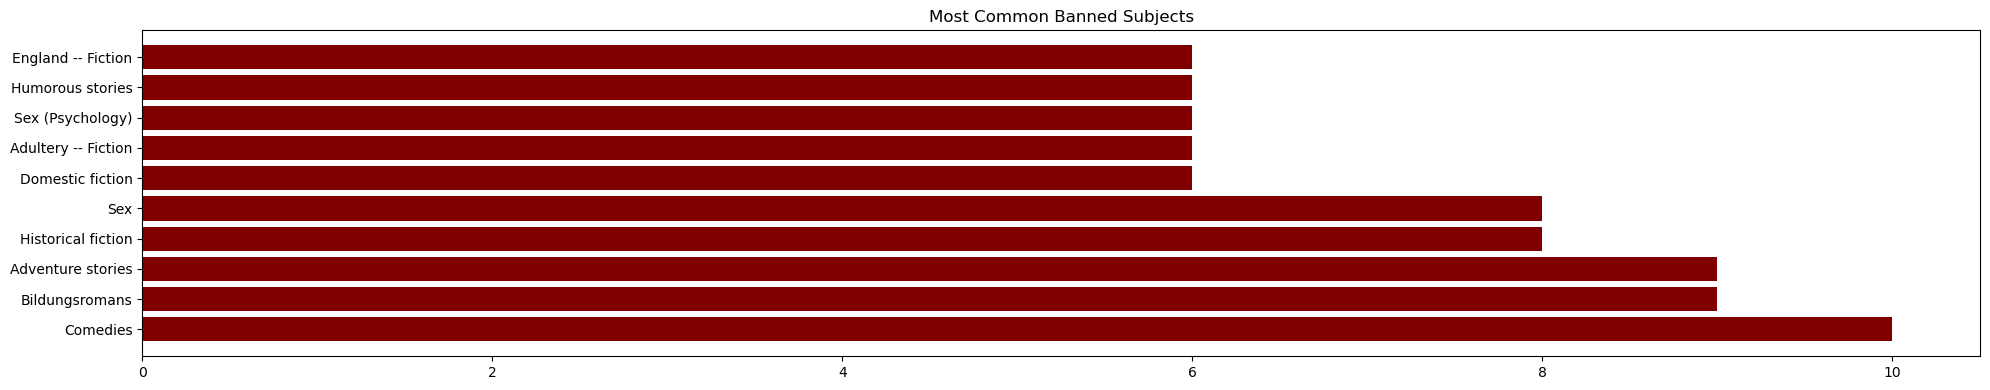

In [359]:
#Top 10 common subjects for banned books
banned_subjects = df_banned_books["subjects"].explode().value_counts()
plt.figure(figsize=(20, 4))
books = banned_subjects.tolist()
subjects = banned_subjects.index.values.tolist()

df = pd.DataFrame({"books": books, "subjects": subjects})
df.set_index("subjects")

df = df.sort_values(by="books", ascending=False).head(10)

plt.barh(df["subjects"], df["books"], color="maroon")
plt.title("Most Common Banned Subjects")
plt.tight_layout()

As expected, the most common subjects of banned books are sensitive topics like sex and adultery.

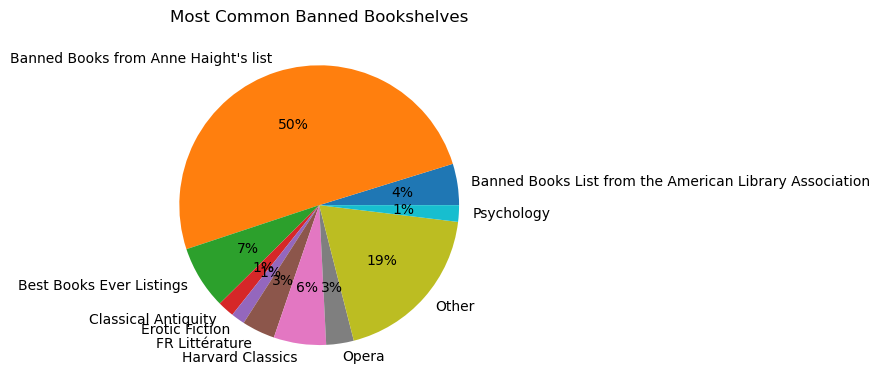

In [360]:
#Most common bookshelves for banned books
banned_bookshelves = df_banned_books["bookshelves"].explode().value_counts()
plt.figure(figsize=(20, 4))
books = banned_bookshelves.tolist()
bookshelves = banned_bookshelves.index.values.tolist()

df = pd.DataFrame({"books": books, "bookshelves": bookshelves})
df.set_index("bookshelves")
df.loc[df["books"] < 5, "bookshelves"] = "Other"

df = df.groupby("bookshelves")["books"].sum().reset_index()

books = df["books"].tolist()
bookshelves = df["bookshelves"].tolist()

plt.pie(books, labels=bookshelves, autopct="%d%%")
plt.title("Most Common Banned Bookshelves")
plt.tight_layout()

Surprisingly, some of the most common bookshelves in banned books are the Best Books Ever Listings, and Harvard Classics.

#### Popularity of Banned Books over Time

For this plot, I will only look at the banned books after 1500, as previous banned books provide very little insight due to their obscurity. 

(1500.0, 1898.0)

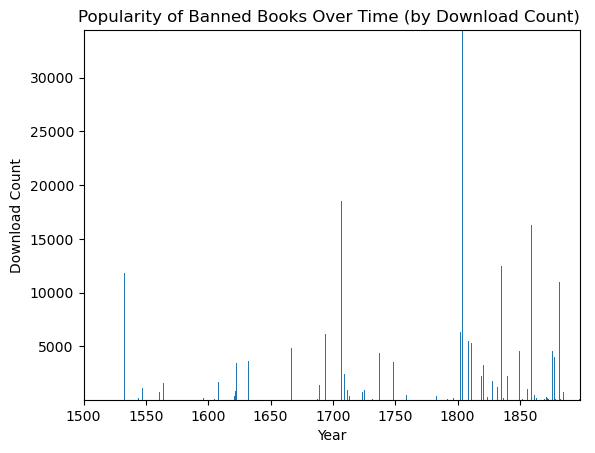

In [361]:
plt.bar(df_banned_books["author_birth_year"], df_banned_books["download_count"])
plt.title("Popularity of Banned Books Over Time (by Download Count) ")
plt.xlabel("Year")
plt.ylabel("Download Count")
# adjust the axis limits
plt.ylim(df_banned_books["download_count"].min(),df_banned_books["download_count"].max())
plt.xlim(1500, df_banned_books["author_birth_year"].max())

Most banned books tend to be between 1700-1900, with the most popular between the 1800s and 1900s.

### Most Common Subjects

Now we will look back at our complete dataframe of books, banned and unbanned.

I will use the explode() function to transform the list of subjects/bookshelves into repeated entries of books, one for each subject/column. This will allow me to search for the most common subjects/bookshelves for further data analysis.

In [362]:
#Most common subjects
df_common_subjects = df_books['subjects'].explode()
common_subjects = df_common_subjects.value_counts().head(10)
common_subjects

Science fiction                       1322
Short stories                         1011
Adventure stories                      537
Fiction                                523
Detective and mystery stories          406
Historical fiction                     393
Love stories                           391
Man-woman relationships -- Fiction     331
England -- Fiction                     300
Fairy tales                            275
Name: subjects, dtype: int64

This dataframe contains more values than there were in the original dataframe.

This is because it creates a new entry for each subject in each book.

For this reason, statistical analysis on it would not be very accurate to the original dataframe.

In [363]:
#However, we can still get some important information from describe()
df_common_subjects.describe()

count               73069
unique              23269
top       Science fiction
freq                 1322
Name: subjects, dtype: object

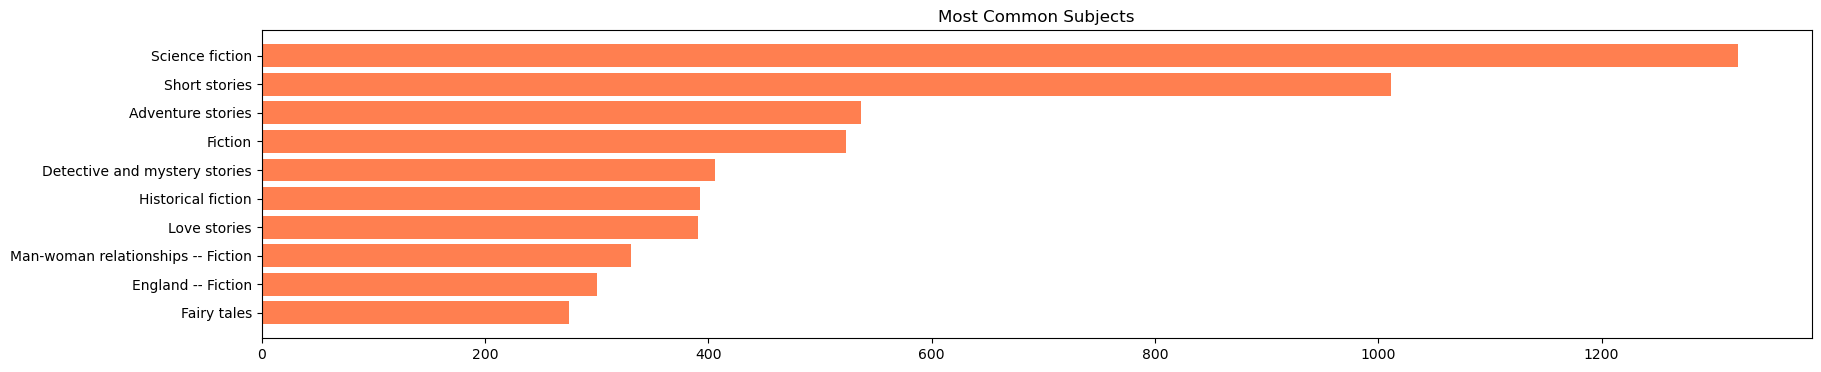

In [364]:
#Top 100 Most common subjects
plt.figure(figsize=(20, 4))
books = common_subjects.tolist()
subjects = common_subjects.index.values.tolist()

df = pd.DataFrame({"books": books, "subjects": subjects})
df.set_index("subjects")
df = df.sort_values(by="books")

plt.barh(df["subjects"], df["books"], color="coral")
plt.title("Most Common Subjects");

As we saw previously with the youngest and eldest authors, fiction and short stories are a very popular subject. 

Other popular subjects include adventure stories, detective and mystery stories, as well as love stories.

### Most Common Bookshelves

In [365]:
df_common_bookshelves = df_books["bookshelves"].explode()
common_bookshelves = df_common_bookshelves.value_counts().head(10)
common_bookshelves

Science Fiction                         779
FR Littérature                          428
Children's Literature                   250
Bestsellers, American, 1895-1923        222
Best Books Ever Listings                187
Children's Book Series                  170
Children's Fiction                      170
Historical Fiction                      162
Harvard Classics                        162
Banned Books from Anne Haight's list    158
Name: bookshelves, dtype: int64

In [366]:
df_common_bookshelves.describe()

count                9907
unique                310
top       Science Fiction
freq                  779
Name: bookshelves, dtype: object

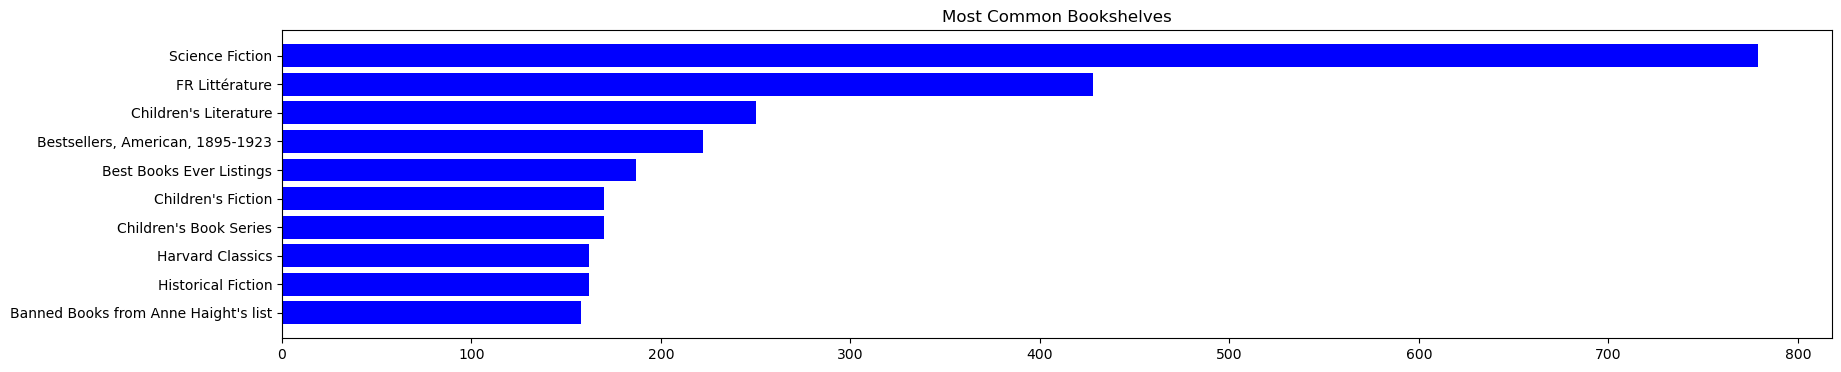

In [367]:
#Top 100 Most common bookshelves

plt.figure(figsize=(20, 4))
books = common_bookshelves.tolist()
bookshelves = common_bookshelves.index.values.tolist()

df = pd.DataFrame({"books": books, "bookshelves": bookshelves})
df.set_index("bookshelves")

df = df.sort_values(by="books")

plt.barh(df["bookshelves"], df["books"], color="blue")
plt.title("Most Common Bookshelves");

Once again, science fiction is very popular. 

However, we also see other new genres, such as french literature, many children books, bestsellers, harvard classics, and even banned books from Anne Haight's list.

### Media

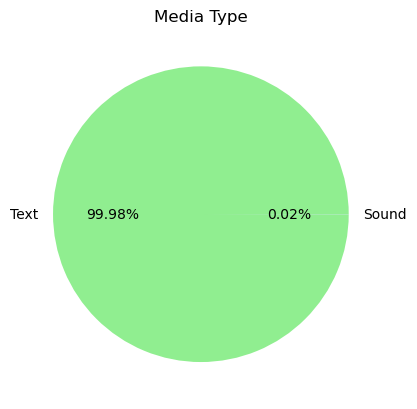

In [368]:
#Type of media of books
colors = ["lightgreen", "lightblue"]
ser = df_books["media_type"].value_counts()
media_type = ser.tolist()
media = ser.index.values.tolist()

df = pd.DataFrame({"media_type": media_type, "media": media})
df.set_index("media")

plt.pie(df["media_type"], labels=df["media"], autopct="%.2f%%", colors=colors);
plt.title("Media Type");

As expected, the overwhelming majority of books are in text. There is an almost negligible number of books in sound format. I will take a deeper look into them:

In [369]:
df_books[df_books["media_type"] == "Sound"]

,title,subjects,bookshelves,copyright,media_type,formats,download_count,author_name,author_birth_year,author_death_year,language,author_age,author_age_category
28731,The Monkey's Paw,"[Horror tales, Wishes -- Fiction]",[],False,Sound,{'audio/ogg': 'http://www.gutenberg.org/files/...,205,"Jacobs, W. W. (William Wymark)",1863.0,1943.0,en,80.0,"[80, 90)"
28733,The Adventures of Sherlock Holmes,"[Detective and mystery stories, English, Holme...",[],False,Sound,{'audio/ogg': 'http://www.gutenberg.org/files/...,172,"Doyle, Arthur Conan",1859.0,1930.0,en,71.0,"[70, 80)"
28794,"Moby Dick; Or, The Whale","[Adventure stories, Ahab, Captain (Fictitious ...",[Best Books Ever Listings],False,Sound,{'audio/ogg': 'http://www.gutenberg.org/files/...,329,"Melville, Herman",1819.0,1891.0,en,72.0,"[70, 80)"
28797,The Odyssey,"[Epic poetry, Greek -- Translations into Engli...",[],False,Sound,{'audio/ogg': 'http://www.gutenberg.org/files/...,321,Homer,-750.0,-650.0,en,100.0,"[100, 110)"
28842,"Don Quixote, Volume 1","[Knights and knighthood -- Spain -- Fiction, P...","[6 Best Loved Spanish Literary Classics, Best ...",False,Sound,{'audio/ogg': 'http://www.gutenberg.org/files/...,144,"Cervantes Saavedra, Miguel de",1547.0,1616.0,en,69.0,"[60, 70)"
28939,This Side of Paradise,"[Advertising -- Fiction, Bildungsromans, Child...",[],False,Sound,{'audio/ogg': 'http://www.gutenberg.org/files/...,114,"Fitzgerald, F. Scott (Francis Scott)",1896.0,1940.0,en,44.0,"[40, 50)"
28946,Gulliver's Travels,"[Fantasy fiction, Gulliver, Lemuel (Fictitious...",[],False,Sound,{'audio/ogg': 'http://www.gutenberg.org/files/...,103,"Swift, Jonathan",1667.0,1745.0,en,78.0,"[70, 80)"


There are only 7 books in audio format - namely very popular book titles converted into sound. 

We can see from the download count that they are not very popular.

### Copyright

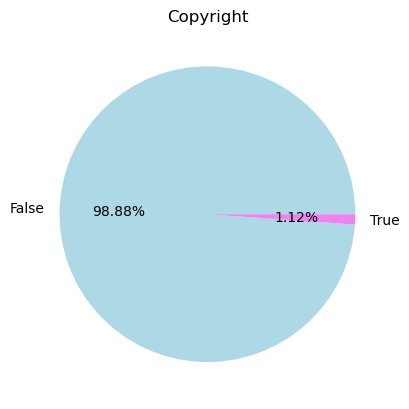

In [370]:
#Copyright on books
colors = ["lightblue", "violet"]

ser = df_books["copyright"].value_counts()
boolean = ser.tolist()
copyright = ser.index.values.tolist()

df = pd.DataFrame({"boolean": boolean, "copyright": copyright})
df.set_index("copyright")

plt.pie(df["boolean"], labels=df["copyright"], colors=colors, autopct="%.2f%%")
plt.title("Copyright");

There is a very small number of books with copyright. Let's take a closer look:

In [371]:
df_copyright = df_books[df_books["copyright"] == True]

df_copyright.shape

(332, 13)

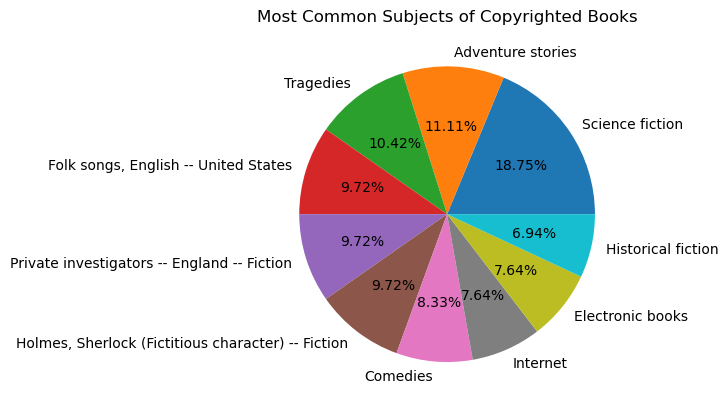

In [372]:
#Most Common Subjects of Copyrighted Books

ser = df_copyright["subjects"].explode().value_counts().head(10)
books = ser.tolist()
subjects = ser.index.values.tolist()

df = pd.DataFrame({"books": books, "subjects": subjects})
df.set_index("subjects")

plt.pie(df["books"], labels=df["subjects"], autopct="%.2f%%")
plt.title("Most Common Subjects of Copyrighted Books");

There are 332 books with protected by copyright. 

Timeless genres like fiction and comedy still appear here, showing their enduring popularity.

However, there are newer subjects like electronic books and the internet, aligning logically with the copyrighted domain. 

This dynamix mix reflects the evolving literary landscapes, where classics persist alongside contemporary themes, encapsulating a diverse array of subjects protected by copyright over time.

### Languages

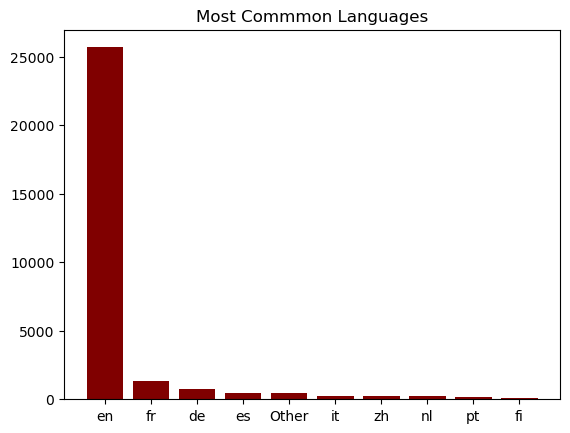

In [373]:
#Most common languages 

ser = df_books["language"].value_counts()
books = ser.tolist()
languages = ser.index.values.tolist()

df = pd.DataFrame({"books": books, "languages": languages})
df.set_index("languages")

df.loc[df["books"] < 100, "languages"] = "Other"

df = df.groupby("languages")["books"].sum().reset_index()
df = df.sort_values(by="books", ascending=False)

plt.bar(df["languages"], df["books"], align="center", color="maroon")
plt.title("Most Commmon Languages");

As expected, English is overwhelmingly common.

The second most common language is french, which is reflected in french literature being one of the most common bookshelves.

### Formats 


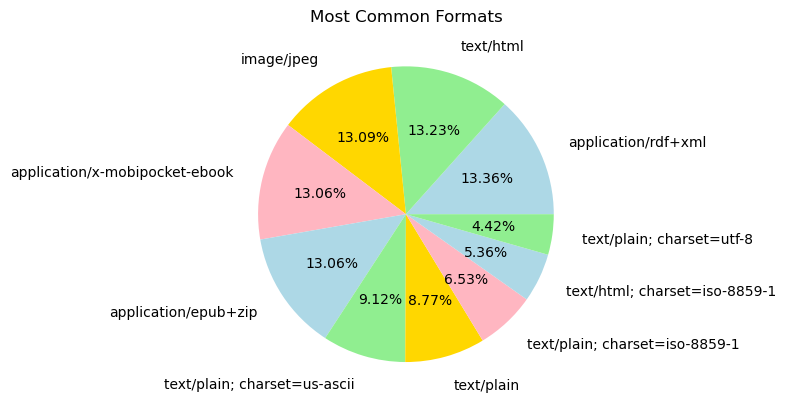

In [397]:
#Most common formats
colors = ["lightblue", "lightgreen", "gold", "lightpink"]
ser = df_books["formats"].explode().value_counts().head(10)
books = ser.tolist()
formats = ser.index.values.tolist()

df = pd.DataFrame({"books": books, "formats": formats})
df.set_index("formats")

plt.pie(df["books"], labels=df["formats"], colors=colors, autopct="%.2f%%", labeldistance=1.2)
plt.title("Most Common Formats");

There are various formats, with the most popular formats being different types of texts, with applications and occasionally JPEG images following suit.

This makes sense as most books would be in textual in nature. Some books have been converted to applications to be used electronically, reflecting contemporary trends of ebooks. 

The different formats showcase the adaptability of literature in the modern digital age.

### Further Analysis on Most Common Subjects

I will make 5 dataframes containing the data of the top 5 most common subjects. 

I will use the complete dataframe here so that we can analyse the years accurately.

In [375]:
subject_names = ["Science fiction", "Short stories", "Adventure stories", "Historical fiction", "Love stories"]

#Dictionary to hold the dataframes for each subject
df_common_subjects = {} 

#Creating the dataframes
common_subjects = (df_books_complete.explode('subjects'))

for i in range(len(subject_names)):
        df_common_subjects[subject_names[i]] = common_subjects[common_subjects["subjects"] == subject_names[i]]


#Making sure we got the same number of rows for each subject
for name in subject_names:
    print("%s shape: %s" % (name, df_common_subjects[name].shape))

Science fiction shape: (1159, 12)
Short stories shape: (837, 12)
Adventure stories shape: (461, 12)
Historical fiction shape: (381, 12)
Love stories shape: (379, 12)


I will make a function to look at the statistics of numerical data for each subject. 

Numerical data here is download_count, author_birth_year, and author_death_year.

In [376]:
def compute_stats(field):
    rows = []
    for subject_name in subject_names:
        row = {"Subject": subject_name}
        row["Min"] = df_common_subjects[subject_name][field].min()
        row["Max"] = df_common_subjects[subject_name][field].max()
        row["Mean"] = df_common_subjects[subject_name][field].mean()
        row["Median"] = df_common_subjects[subject_name][field].median()
        rows.append(row)
        
    return pd.DataFrame(rows).set_index("Subject")

In [377]:
compute_stats("download_count")

,Min,Max,Mean,Median
Subject,,,,
Science fiction,36,58506,225.559965,59.0
Short stories,36,10217,186.346476,60.0
Adventure stories,36,49674,368.281996,64.0
Historical fiction,36,34410,391.028871,78.0
Love stories,36,58114,638.598945,76.0


Love stories are most popular on average, followed by adventure stories, and historical fiction. 

Short stories is least popular by average, which may reveal readers' preferences for longer pieces of text.

Science fiction and Love stories have one of the highest download counts of all time, which is expected as they are very popular genres.

In [378]:
compute_stats("author_age")

,Min,Max,Mean,Median
Subject,,,,
Science fiction,33.0,98.0,73.448663,75.0
Short stories,25.0,98.0,70.379928,72.0
Adventure stories,30.0,98.0,69.707158,72.0
Historical fiction,29.0,94.0,67.524934,68.0
Love stories,26.0,100.0,68.139842,69.0


Author age is very similar among all genres. 

Science fiction has the oldest average age, which was reflected in the eldest authors analysis earlier on.

In [379]:
compute_stats("author_birth_year")

,Min,Max,Mean,Median
Subject,,,,
Science fiction,1694.0,1939.0,1903.204487,1913.0
Short stories,1672.0,1939.0,1889.354839,1906.0
Adventure stories,1567.0,1931.0,1857.657267,1862.0
Historical fiction,1634.0,1933.0,1830.923885,1833.0
Love stories,1634.0,1923.0,1844.213720,1856.0


In [380]:
compute_stats("author_death_year")

,Min,Max,Mean,Median
Subject,,,,
Science fiction,1778.0,2023.0,1976.653149,1986.0
Short stories,1719.0,2023.0,1959.734767,1975.0
Adventure stories,1601.0,2013.0,1927.364425,1925.0
Historical fiction,1693.0,2005.0,1898.448819,1901.0
Love stories,1693.0,2002.0,1912.353562,1924.0


Most genres exhibit similar trends in author birth year and death year.

However, historical fiction tends to have authors born in earlier decades on average, whereas science fiction shows authors born in later decades compared to other genres.

There is an approximate 85 years difference in the median author birth and death years between science fiction and historical fiction.

(Science fiction: 1903-1977, Historical fiction: 1831-1898)

This suggests that science fiction gained significant popularity nearly eight decades after historical fiction reached its peak, indicating an evolution in readers' preferences and literary trends over the years.

Next, I would like to plot each subject for the different years.
To do so, I will first order the books by year.

In [381]:
#Sorting each dataframe by year 
for subject_name in subject_names:
    df_common_subjects[subject_name] = df_common_subjects[subject_name].sort_values(by="author_birth_year")

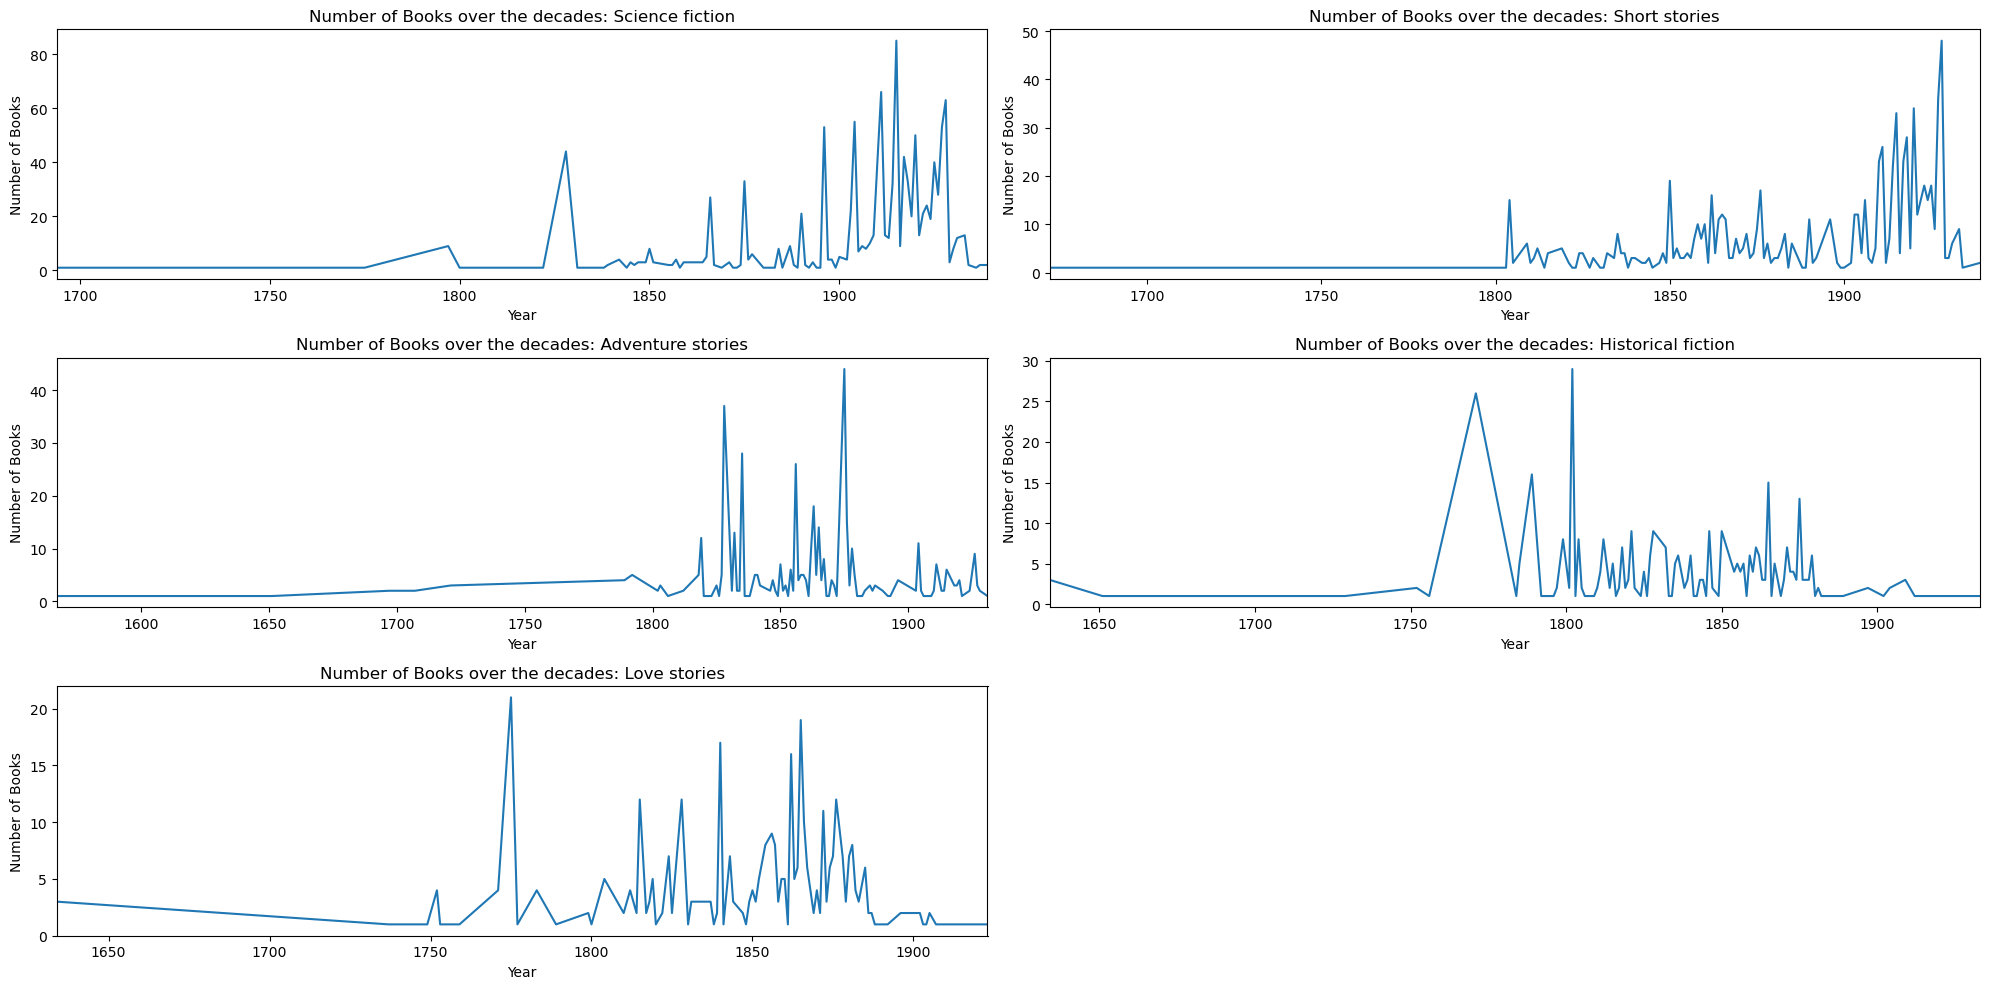

In [382]:
fig = plt.figure(figsize=(20, 10))
for i, subject_name in enumerate(subject_names):
    axc = fig.add_subplot(3, 2, i+1)
    ax = df_common_subjects[subject_name]["author_birth_year"].value_counts(sort=False).plot.line(ax=axc)
    ax.set_title("Number of Books over the decades: %s" % subject_name)
    ax.set_ylabel("Number of Books")
    ax.set_xlabel("Year")
    ax.set_xlim(df_common_subjects[subject_name]["author_birth_year"].min(), df_common_subjects[subject_name]["author_birth_year"].max())
fig.tight_layout()

We can see that each genre has its distinct trends over the centuries. Most genres emerged from the 1650s and 1700s, establishing a foundation of literary diversity,

Science fiction gained significant popularity just before the 1900s, though its popularity decreased towards the 1950s.

Short stories peaked around the same time, showing a steady incline since the 1800s.

Adventure stories reached their peak in the mid 1850s and continued until around the 1900s.

Historical fiction was more popular earlier on, as indicated by our statistics computations. It peaked the earliest, around the 1750s-1800s, and has declined by the 1900s.

Love stories followed a similar trajectory, peaking around 1775, and finally declining around 1900s.

I would like to note that this is not entirely accurate as we use the author birth year as an approximation for the books' popularity timeline instead of the exact year of book publication. 

While not very precise, it provides valuable insights into the evolving landscape of literary genres and the changing preferences of readers across the different eras.

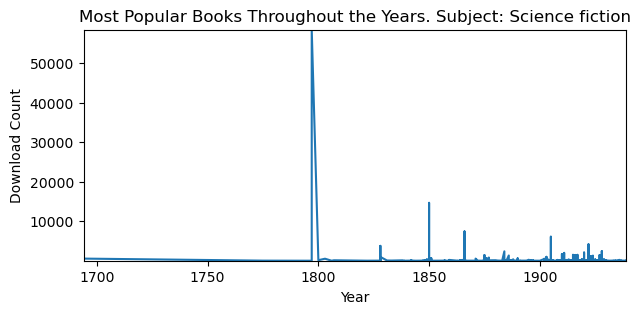

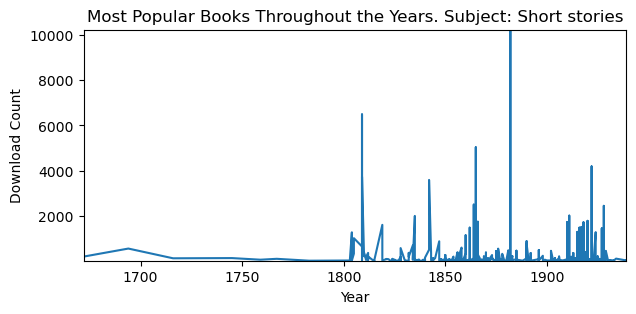

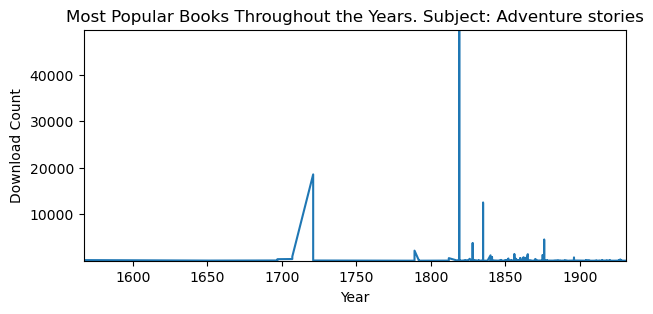

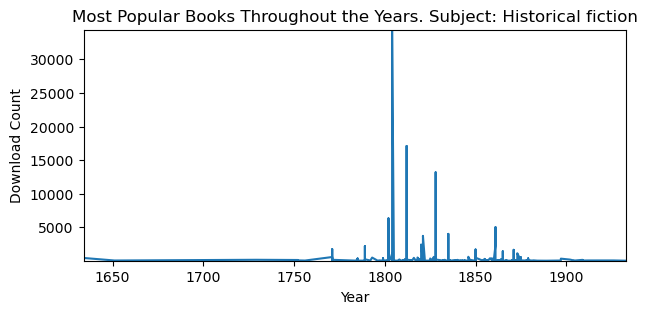

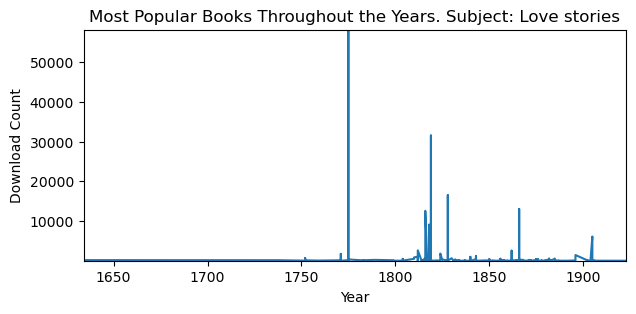

In [383]:
#Popularity throughout years of books (by download count)
for subject_name in subject_names:
    fig = plt.figure(figsize=(7, 3))
    plt.plot(df_common_subjects[subject_name]["author_birth_year"], df_common_subjects[subject_name]["download_count"])
    plt.title("Most Popular Books Throughout the Years. Subject: %s" % subject_name)
    plt.xlabel("Year")
    plt.ylabel("Download Count")
    plt.xlim(df_common_subjects[subject_name]["author_birth_year"].min(), df_common_subjects[subject_name]["author_birth_year"].max())
    plt.ylim(df_common_subjects[subject_name]["download_count"].min(), df_common_subjects[subject_name]["download_count"].max())

Here we see the popularity of books of different genres in terms of download count instead of the number of books.

We can see that the most popular time for each genre is around the 1800s.

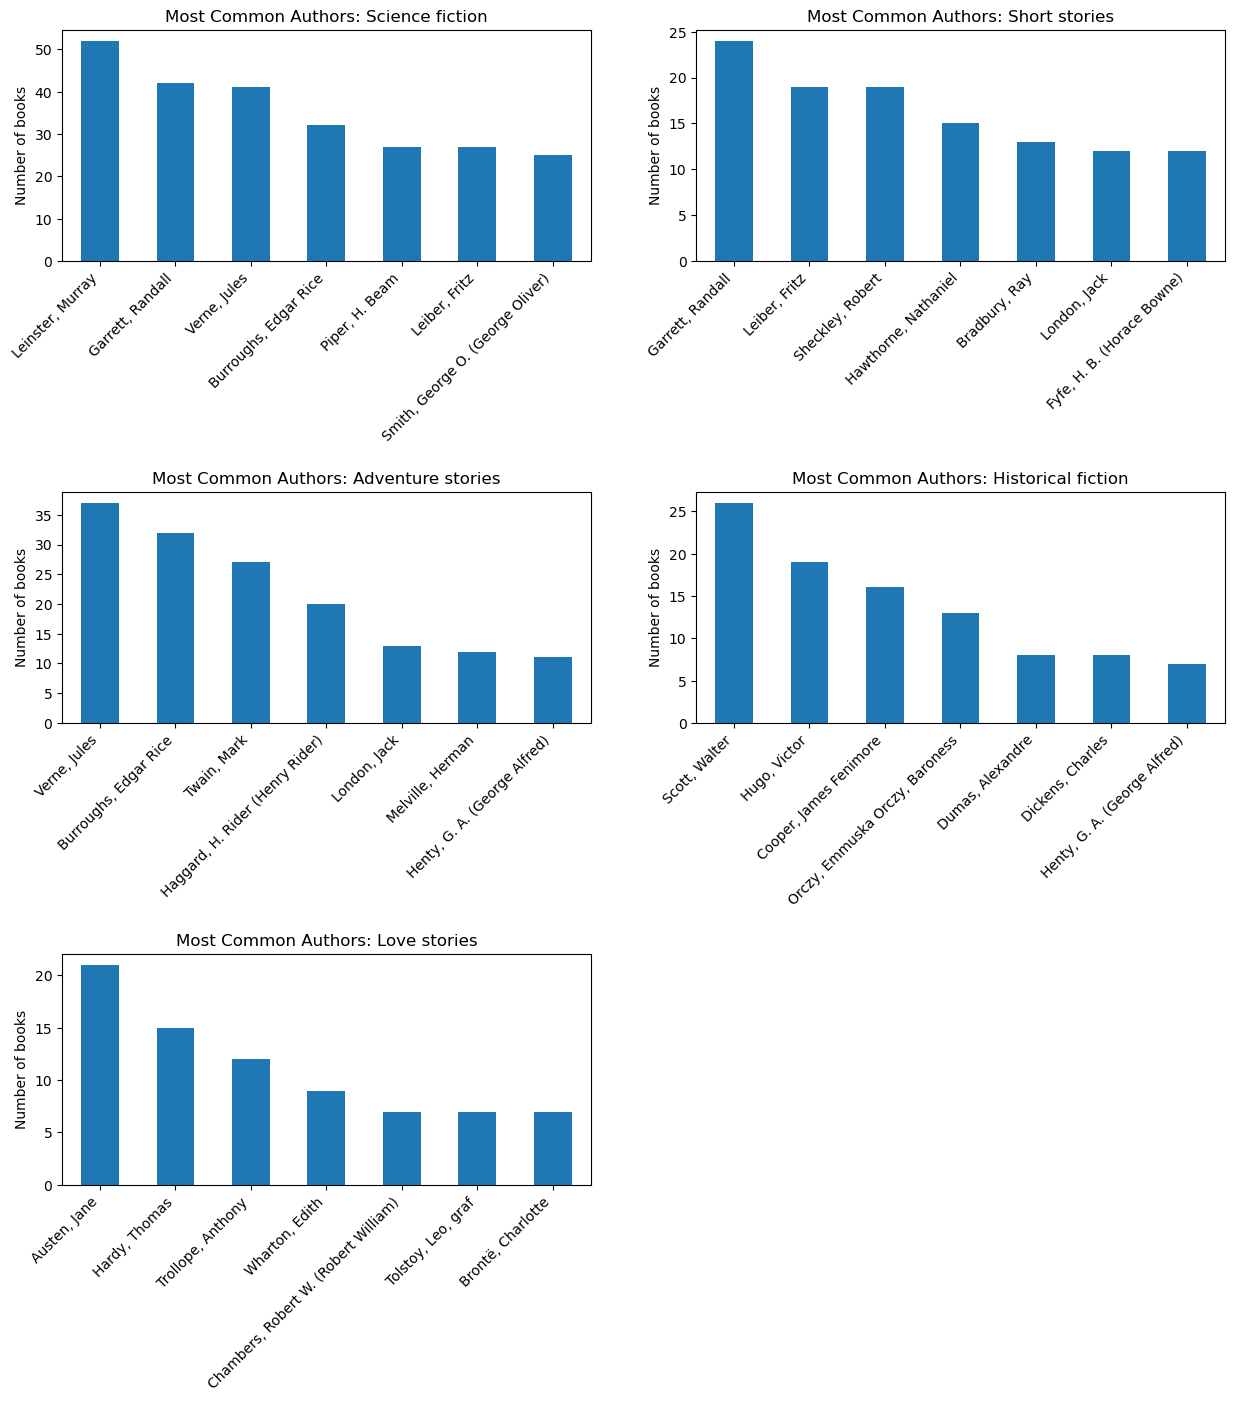

In [384]:
#Most common authors + number of their works
fig = plt.figure(figsize=(15, 15))
    
for i, subject_name in enumerate(subject_names): 
    axc = fig.add_subplot(3, 2, i+1)
    ser = df_common_subjects[subject_name]["author_name"].value_counts().head(7).plot.bar(ax=axc)
    ser.set_title("Most Common Authors: %s" % subject_name);
    ser.set_ylabel("Number of books")
    plt.xticks(rotation=45, ha='right');

plt.subplots_adjust(hspace=1)

Here we see the most popular authors in each genre. We can even see authors reappear in different genres, like Fritz Leiber and Randall Garrett.

Popular authors like Twain Mark and Charles Dickens appear here too.

Show trends/popularity of different subjects:

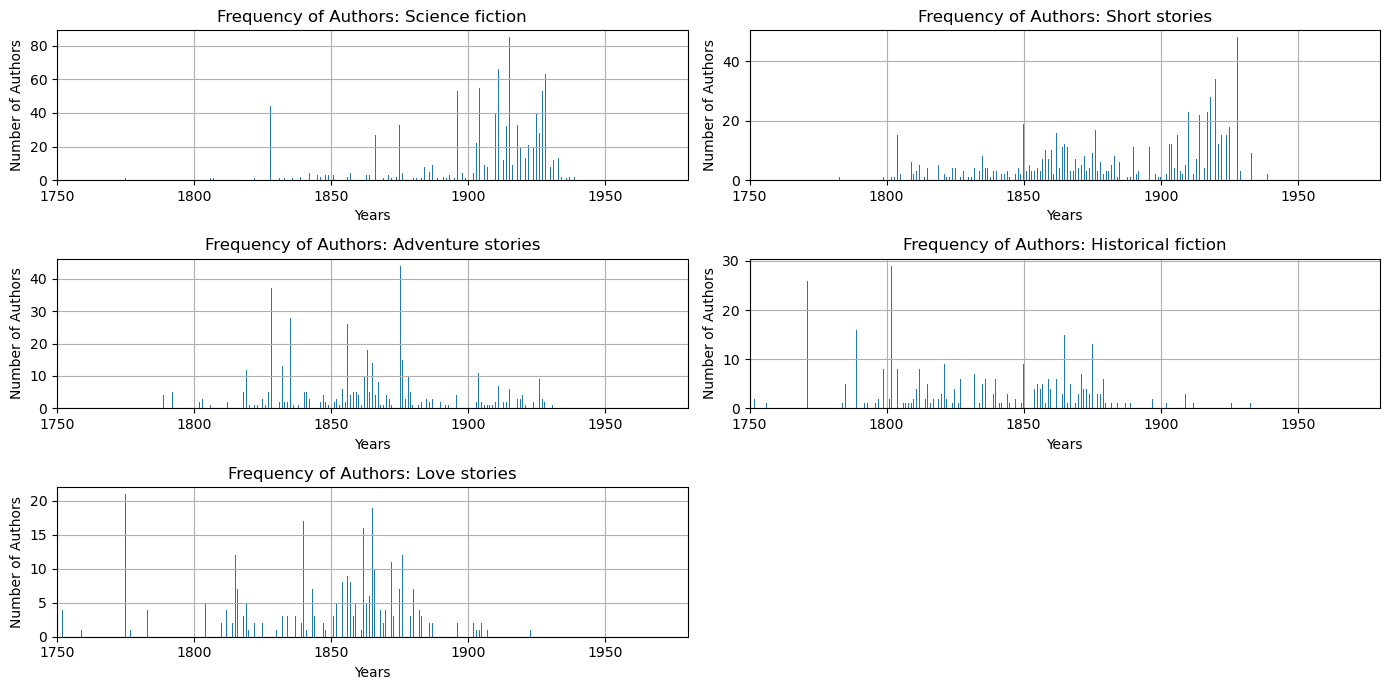

In [385]:
#Fix limits later
fig = plt.figure(figsize=(14, 7))
for i, subject_name in enumerate(subject_names):
    axc = fig.add_subplot(3, 2, i+1)
    ax = df_common_subjects[subject_name]["author_birth_year"].hist(ax=axc, bins = 1000)
    ax.set_xlim(1750, 1980)
    ax.set_title("Frequency of Authors: %s" % subject_name)
    ax.set_ylabel("Number of Authors")
    ax.set_xlabel("Years")
fig.tight_layout()

We can see that the number of authors is very large in the most common genre, Science fiction, and is lowest in the least common genre, Loves stories.

Interestingly, the 3 most common genres persevere after the 1900s, while the 2 least common ones taper off at that time.

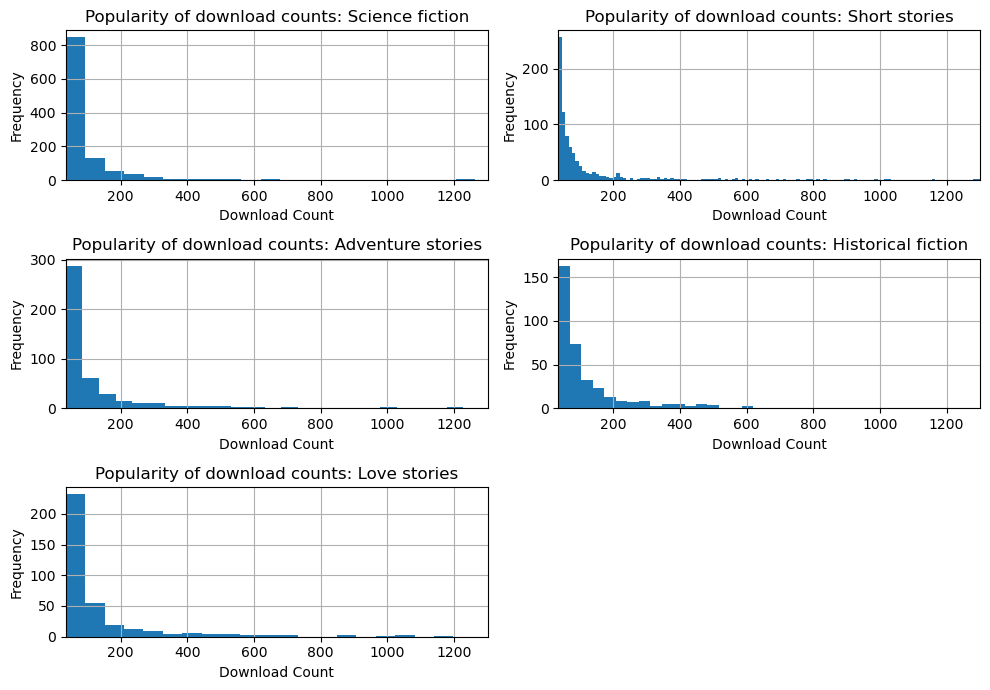

In [386]:
fig = plt.figure(figsize=(10, 7))
for i, subject_name in enumerate(subject_names):
    axc = fig.add_subplot(3, 2, i+1)
    ax = df_common_subjects[subject_name]["download_count"].hist(ax=axc, bins = 1000)
    ax.set_xlim(df_common_subjects[subject_name]["download_count"].min(),1300)
    ax.set_title("Popularity of download counts: %s" % subject_name)
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Download Count")
fig.tight_layout()

We can see that across all genres, most books are below the mean of approximately 200 downloads.

## Relationships between fields in df_books

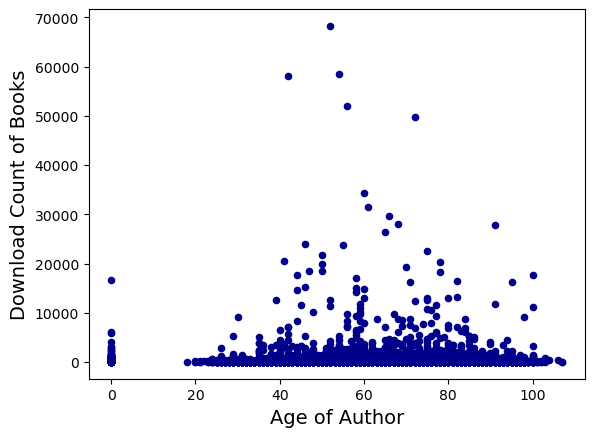

In [387]:
ax = df_books.plot(kind="scatter", color='darkblue', x="author_age", y="download_count")
plt.xlabel("Age of Author", fontsize=14)
plt.ylabel("Download Count of Books", fontsize=14);

The most popular books tend to be made by authors of age 40-70, which is below the average author age of 70.

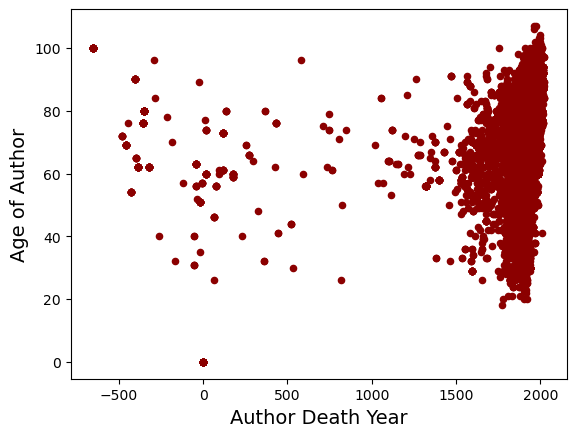

In [388]:
ax = df_books.plot(kind="scatter", color='darkred', x="author_death_year", y="author_age")
plt.xlabel("Author Death Year", fontsize=14)
plt.ylabel("Age of Author", fontsize=14);

Here we can see that most authors were between the 1500s and 2000s, following the invention of the printing press.

Interestingly, the average age of authors from 500 BC to 500 seems to be slightly higher than that of the more modern authors/

Next I will make a heatmap of the fields to see the similarities between the fields:

In [389]:
import numpy as np
def plot_heatmap(title, df_in, figsize=(5.5, 5)):
    df_corr = df_in.corr()
    # create a color palettte
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_corr, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title(title)

C:\Users\amyta\AppData\Local\Temp\ipykernel_4276\892108750.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_in.corr()


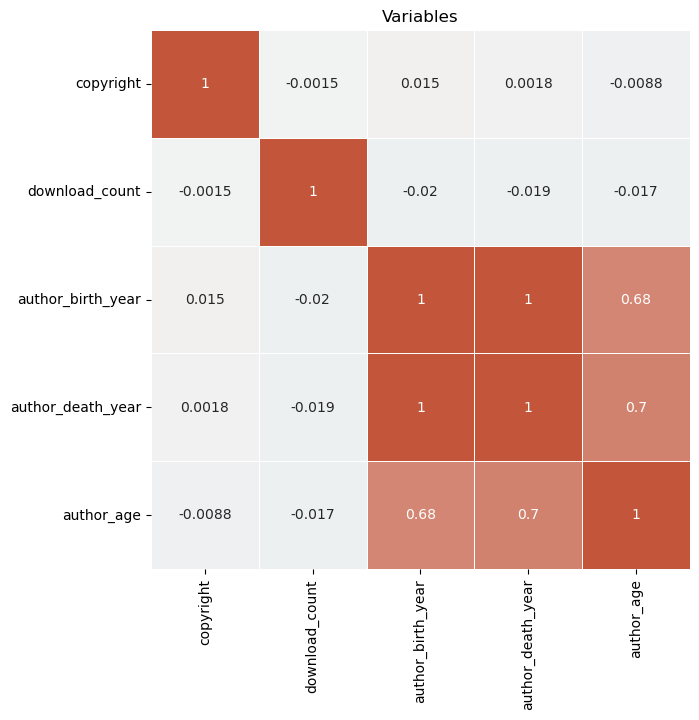

In [390]:
plot_heatmap("Variables", df_books, figsize=(11,7))

Most variables have no relationship with each other, as expected.

However, we see a very clear relationship between author birth year and death year. This correlation is not surprising, as authors have similar lifespan lengths on average.

We also see a strong relationship between the author age and their birth year, and death year respectively, which is also obvious, as the age was calculated from those two variables.

## Book Formats

I will look at the different formats books can come in.

Specifically, the percentage of books that have a certain format in each subject.

In [391]:
#Formats
text_counts = {}
for subject_name in subject_names:
    counts = df_common_subjects[subject_name]["formats"].explode().value_counts()
    # convert to percentage
    text_counts[subject_name] = (counts*100.0)/len(df_common_subjects[subject_name])
# convert to a DataFrame and fill the missing value with 0s
# i.e. descriptions which don't appear for a given city
df_text_counts = pd.DataFrame(text_counts).fillna(0)
df_text_counts

,Science fiction,Short stories,Adventure stories,Historical fiction,Love stories
application/epub+zip,97.584124,99.044205,93.492408,97.375328,94.195251
application/msword,0.000000,0.000000,0.000000,0.787402,0.000000
application/octet-stream,23.727351,22.819594,22.559653,18.897638,19.525066
application/pdf,0.862813,0.477897,2.386117,3.674541,2.902375
application/prs.tei,0.258844,0.000000,0.000000,1.049869,0.000000
application/prs.tex,0.086281,0.000000,0.000000,0.000000,0.000000
application/rdf+xml,100.000000,100.000000,100.000000,100.000000,100.000000
application/x-mobipocket-ebook,97.584124,99.044205,93.492408,97.375328,94.195251
audio/mp4,1.207938,0.477897,3.687636,1.837270,3.957784
audio/mpeg,2.415876,0.955795,6.507592,2.624672,5.804749


The most frequent format for each subject:

In [392]:
df_text_counts.idxmax()

Science fiction       application/rdf+xml
Short stories         application/rdf+xml
Adventure stories     application/rdf+xml
Historical fiction    application/rdf+xml
Love stories          application/rdf+xml
dtype: object

I will visually present this frequency information using bar plots:

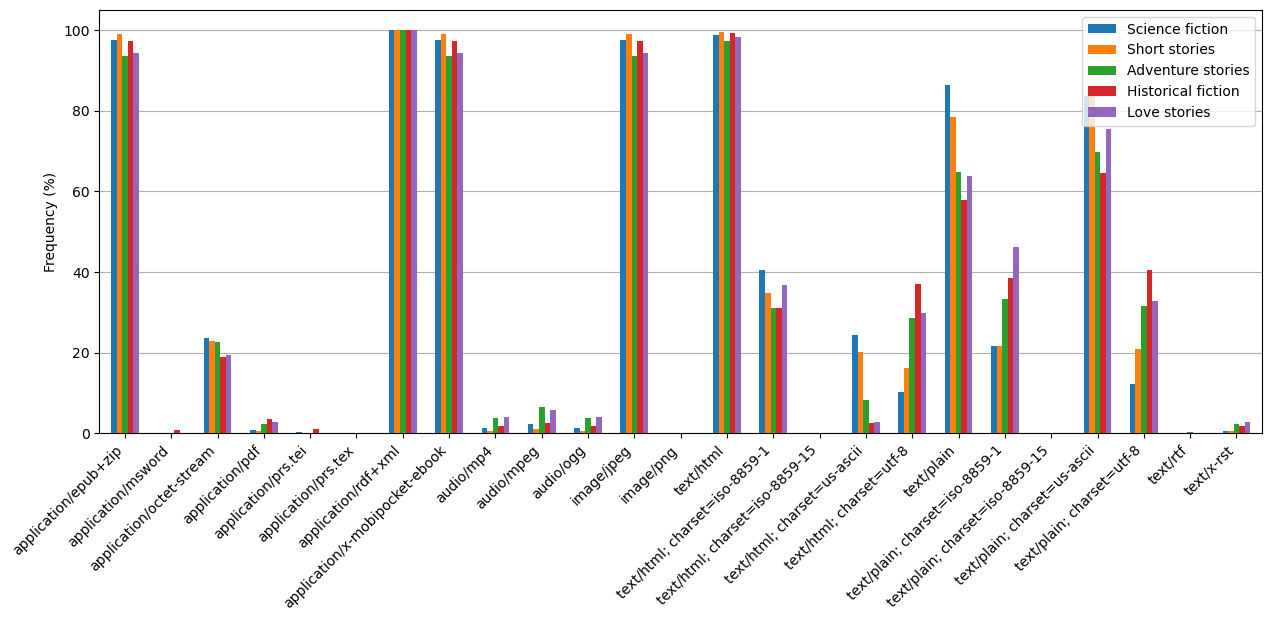

In [393]:
ax = df_text_counts.plot.bar(figsize=(15,5.5), width=0.6,zorder=3)
ax.legend()
ax.set_ylabel("Frequency (%)")
ax.yaxis.grid(True)
# adjust the x-axis label rotation
plt.xticks(rotation=45, ha='right');

Alternatively, to make this clearer, I will use a heatmap representation to display the full set of percentages for the different book formats:

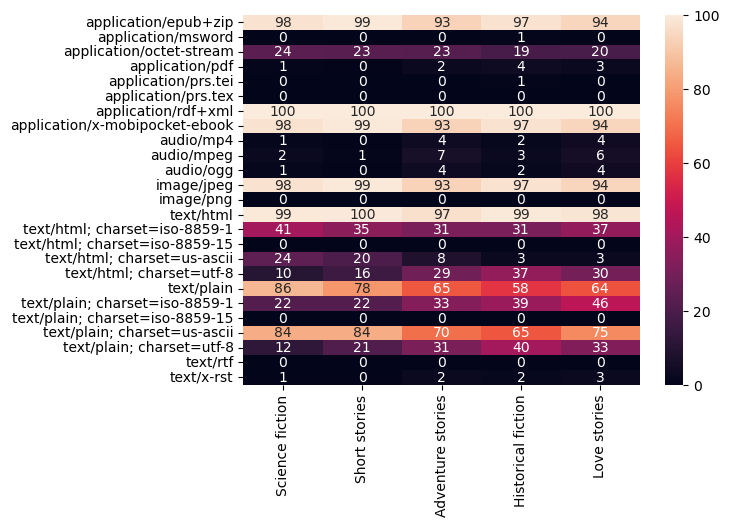

In [394]:
# display the heatmap, with percentages rounded to nearest integer
f, ax = plt.subplots()
h = sns.heatmap(df_text_counts, square=False, annot=True, fmt='.0f')

The formats are more or less the same across all genres for applications, audio, and images. They mostly differ in text.

More popular book formats like xml applications, zip applications, and ebook applications, plain text, html text are used most often in all genres.

The most stark difference in genres is for the "text/html; charset=utf-8" format.

### Discussion and Conclusions

#### Challenges from Data Collection
A challenge I faced during data collection was the vast diversity of books available on the Gutendex. Searching for specific genres did not produce enough results for analysis. Instead, I decided to collect a large dataset of books of a wide range of genres to accurately identify patterns and trends of books of all types. Later on, during data analysis, I analysed the data of different genres and compared them. It was also difficult to work with multi-valued columns, specifically those containing lists and dictionaries. 

#### Key Insights from Data Analysis:

- The data highlighted the significant influence of the printing press on the popularity and frequency of books. The surge in book production around the 1500s, especially between the 1800s and 1900s, reflected the technological advancements and availability of the printing press.

- Each genre exhibits distinct historical trends. Historical fiction and love stories, for example, peaked in popularity earlier than other genres, indicating changing reader preferences over time. Science fiction emerged as a popular genre nearly 80 years after historical fiction, highlighting evolving literary trends.

#### Further Analysis Suggestions:

- Further exploration into specific genres can provide deeper insights into the factors influencing their popularity during differennt historical periods.

- If reader data was available, exploring reader demographics and preferences could enhance the understanding of the audience behind the popularity of specific genres and books. Analyzing reader reviews and ratings could offer also offer valuable insights.

- If book publication years was available, we could discover a more accurate perspective on their popularity trends.